# Bayesian Analysis of Locust Movement in Virtual Reality

### Introduction

In this notebook, we analyze the directional movement patterns of locusts navigating a virtual reality (VR) environment. By studying their trajectories, we aim to understand population-level directional tendencies, focusing on specific hypotheses about movement preferences.

Locust movement data exhibit periodic and potentially bimodal patterns, with individuals showing a tendency to switch between distinct directions. To model these behaviors, we use a **hierarchical bimodal von Mises mixture model**, which allows us to capture both shared (population-level) and unique (individual-level) directional characteristics.

This analysis involves several key steps:

- **Data Preprocessing**: We rediscretize locust trajectories to reduce auto-correlation, converting movement paths into directional vectors.
- **Model Specification and Fitting**: We define a Bayesian hierarchical model to fit the directional data and perform inference using Hamiltonian Monte Carlo sampling, specifically utilizing the No-U-Turn Sampler (NUTS) to automate the selection of sampling hyperparameters and maximize sampling efficiency.
- **Model Validation and Hypothesis Testing**: We validate the model through posterior predictive checks and test hypotheses about directional tendencies (e.g., forward and perpendicular movement) relative to a random walk baseline.

To support these steps, we import several essential libraries:

- **Standard library imports**: `random` and `warnings` for general functionality and handling warnings.
- **Numerical packages**: `numpy` and `scipy` for numerical calculations.
- **Data manipulation**: `pandas` for data handling and manipulation.
- **Visualization packages**: `matplotlib` (including `matplotlib.patches`, `matplotlib.lines`, and `matplotlib.legend_handler`) and `seaborn` for creating plots and visualizing data.
- **Statistical modeling packages**: `pymc`, `pytensor`, and `arviz` for Bayesian modeling, tensor calculations, and model diagnostics, leveraging NUTS for efficient sampling.
- **Parallel computing**: `joblib` for parallel processing to speed up data handling and computations.
- **Other utilities**: `numba` for just-in-time (JIT) compilation of certain functions to improve performance, as well as `tqdm` for progress bars.

This notebook will help us gain insights into how locusts navigate within the VR environment, shedding light on potential directional biases in their movement patterns.


In [1]:
# import sys

# Install all required dependencies using the current Python kernel
# !{sys.executable} -m pip install --upgrade --ignore-installed --no-cache-dir \
#     numpy>=1.24.4 \
#     scipy>=1.10.1 \
#     pandas>=2.0.3 \
#     matplotlib>=3.7.5 \
#     seaborn>=0.12.2 \
#     arviz>=0.15.1 \
#     pymc>=5.6.1 \
#     pytensor>=2.12.3 \
#     joblib>=1.1.0 \
#     numba>=0.57.0 \
#     tqdm>=4.66.4


In [1]:
# Standard library imports
import random
import warnings
import sys

# Numerical packages
import numpy as np
import scipy
from scipy.special import i0, iv
from scipy.stats import vonmises

# Data manipulation
import pandas as pd

# Visualization packages
import matplotlib
import matplotlib.lines as mlines
import matplotlib.legend_handler as mlegend_handler
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, FancyArrow
import seaborn as sns

# Statistical modeling packages
import arviz as az
import pymc as pm
import pytensor
import pytensor.tensor as pt

# Parallel computing
import joblib
from joblib import Parallel, delayed

# Other
import numba
from numba import jit
import tqdm as tq
from tqdm.autonotebook import tqdm
from IPython.display import Markdown

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/tmp/ipykernel_1182193/1342970002.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# # Libraries and their versions
# libraries = {
#     "Python": sys.version.split()[0],  # Extracts the Python version
#     "numpy": np.__version__,
#     "scipy": scipy.__version__,
#     "pandas": pd.__version__,
#     "matplotlib": matplotlib.__version__,
#     "seaborn": sns.__version__,
#     "arviz": az.__version__,
#     "pymc": pm.__version__,
#     "pytensor": pytensor.__version__,
#     "joblib": joblib.__version__,
#     "numba": numba.__version__,
#     "tqdm": tq.__version__,
# }

# # Print versions
# for lib, version in libraries.items():
#     print(f"{lib}: {version}")

print(
    """
    Python: 3.8.10
    numpy: 1.24.4
    scipy: 1.10.1
    pandas: 2.0.3
    matplotlib: 3.7.5
    seaborn: 0.12.2
    arviz: 0.15.1
    pymc: 5.6.1
    pytensor: 2.12.3
    joblib: 1.1.0
    numba: 0.57.0
    tqdm: 4.66.4
    """
)


    Python: 3.8.10
    numpy: 1.24.4
    scipy: 1.10.1
    pandas: 2.0.3
    matplotlib: 3.7.5
    seaborn: 0.12.2
    arviz: 0.15.1
    pymc: 5.6.1
    pytensor: 2.12.3
    joblib: 1.1.0
    numba: 0.57.0
    tqdm: 4.66.4
    


### Data Preprocessing: Rediscretization of Trajectories

To analyze the movement patterns of locusts, we preprocess their trajectory data by rediscretizing each path. This step reduces auto-correlation in the movement data by ensuring that consecutive points along each trajectory are separated by a fixed step length. The step length is set to three times the locust body length, which helps balance data density and minimize correlation in directional measurements.

#### Key Parameters
- `BODY_LENGTH`: Set to `0.12`, representing the approximate body length of a locust (in meters).
- `STEP_LENGTH`: Set to `BODY_LENGTH * 3`, defining the distance between points in the rediscretized trajectory.
- `TOLERANCE`: Set to `0.01`, this tolerance allows slight flexibility in the step length to accommodate small deviations.

#### Functions

1. **`densely_interpolate(x, y, tolerance)`**
   - Linearly interpolates points between each pair of original trajectory points `(x, y)` based on a step size determined by `tolerance`.
   - Ensures a dense set of points, aiding in matching the desired step length during rediscretization.

2. **`find_next_point(x, y, start_x, start_y, step_length)`**
   - Finds the next point in the interpolated data that is approximately `step_length` away from a given starting point `(start_x, start_y)`.
   - Calculates Euclidean distances to identify the point closest to the desired step length.

3. **`rediscretize_trajectory(x, y, step_length, tolerance)`**
   - Rediscretizes the original trajectory into evenly spaced points by selecting points from the densely interpolated trajectory at intervals of `step_length`.
   - Avoids points too close to each other (within `TOLERANCE`) to maintain consistent spacing.

These preprocessing steps ensure the trajectory data is suitable for modeling directional movement patterns.


In [3]:
# Define constants for trajectory preprocessing
BODY_LENGTH = 0.12
STEP_LENGTH = BODY_LENGTH * 3
TOLERANCE = 0.01  # Tolerance for the difference in step length

def densely_interpolate(x, y, tolerance=TOLERANCE):
    """
    Linearly interpolate points between given trajectory points.

    Parameters:
    ----------
    x, y : list or ndarray
        Coordinates of the trajectory points.
    tolerance : float
        Maximum allowed distance between interpolated points.

    Returns:
    -------
    tuple
        Densely interpolated x and y coordinates.
    """
    new_x, new_y = [], []
    for i in range(len(x) - 1):
        # Calculate segment length
        segment_length = np.sqrt((x[i + 1] - x[i]) ** 2 + (y[i + 1] - y[i]) ** 2)
        # Determine the number of interpolation points
        num_points = max(int(segment_length / tolerance), 2)  # At least 2 points per segment
        segment_x = np.linspace(x[i], x[i + 1], num_points)
        segment_y = np.linspace(y[i], y[i + 1], num_points)
        if i != 0:
            # Avoid duplicating points in middle segments
            segment_x = segment_x[1:]
            segment_y = segment_y[1:]
        new_x.extend(segment_x)
        new_y.extend(segment_y)
    return new_x, new_y

def find_next_point(x, y, start_x, start_y, step_length):
    """
    Find the next point approximately `step_length` away from a starting point.

    Parameters:
    ----------
    x, y : list or ndarray
        Coordinates of the trajectory points.
    start_x, start_y : float
        Coordinates of the starting point.
    step_length : float
        Desired step length.

    Returns:
    -------
    tuple
        Coordinates of the next point, and its index in the trajectory.
    """
    distances = np.sqrt((np.array(x) - start_x) ** 2 + (np.array(y) - start_y) ** 2)
    # Find the index of the point closest to the desired step length
    index = (np.abs(distances - step_length)).argmin()
    return x[index], y[index], index

def rediscretize_trajectory(x, y, step_length, tolerance=TOLERANCE):
    """
    Rediscretize a trajectory by selecting points at approximately equal intervals.

    Parameters:
    ----------
    x, y : list or ndarray
        Original trajectory coordinates.
    step_length : float
        Desired step length for rediscretization.
    tolerance : float
        Allowed deviation from the desired step length.

    Returns:
    -------
    tuple
        Rediscretized x and y coordinates.
    """
    dense_x, dense_y = densely_interpolate(x, y, tolerance)
    new_x, new_y = [x[0]], [y[0]]  # Start with the first point

    while True:
        if len(dense_x) == 0:  # Stop if no more points to process
            break
        next_x, next_y, index = find_next_point(dense_x, dense_y, new_x[-1], new_y[-1], step_length)
        
        # Calculate distance to the next point
        last_distance = np.sqrt((new_x[-1] - next_x) ** 2 + (new_y[-1] - next_y) ** 2)
        if last_distance < step_length - TOLERANCE:  # Break if the distance is too small
            break
        
        new_x.append(next_x)
        new_y.append(next_y)
        # Remove processed points to avoid revisiting
        dense_x = dense_x[index:]
        dense_y = dense_y[index:]
        
        if index == 0:  # Prevent infinite loops if no progress
            break

    return new_x, new_y


### Data Processing

In this section, we process the raw locust trajectory data to generate rediscretized and directionally annotated trajectories for analysis. The steps involve grouping data by individual, rediscretizing each trajectory, calculating directional differences, and organizing the results into a unified format. Key functions and processing steps are detailed below:

#### Functions

1. **`process_individual(x, y, file_path, fname, step_length=STEP_LENGTH)`**
   - Rediscretizes the trajectory defined by `x` and `y` coordinates using a specified `step_length`.
   - Calculates differences in `x` and `y` (`dX`, `dY`) between consecutive rediscretized points to capture movement direction.
   - Outputs a `DataFrame` with rediscretized coordinates (`X`, `Y`), directional differences (`dX`, `dY`), and metadata (`file_path`, `fname`).

2. **`prepare_tasks(file_path)`**
   - Reads trajectory data from an HDF5 file.
   - Groups data by `fname` (identifier for each trajectory) and prepares a list of tasks, each containing `x`, `y` coordinates and metadata (`file_path`, `fname`) for individual trajectories.

#### Processing Steps

1. **Task Preparation**: 
   - Define the `file_paths` for raw trajectory data (`./raw/XY_raw_50cm_.h5`, `./raw/XY_raw_8cm_.h5`).
   - Use `prepare_tasks(file_path)` to group and organize trajectory data from each file into a list of tasks.

2. **Parallel Processing**:
   - Process the tasks in parallel using `joblib.Parallel` with the `process_individual` function to maximize computational efficiency.
   - Each task is rediscretized and processed to calculate directional differences.

3. **Merging Results**:
   - Combine all the processed results into a single `DataFrame` using `pd.concat`, ensuring all trajectories are organized for subsequent analysis.

4. **Assigning Unique IDs**:
   - Create a unique identifier (`unique_id`) for each trajectory based on `file_path` and `fname`.
   - Map these unique identifiers to integer `animal_id`s for simpler reference and drop the intermediate column.

5. **Calculating Direction**:
   - Compute the movement direction for each rediscretized point using `np.arctan2(dY, dX)`, representing the direction of movement in radians.

The resulting `DataFrame` is ready for downstream analysis, providing rediscretized trajectories, directional differences, and metadata for each locust.


In [4]:
def process_individual(x, y, file_path, fname, step_length=STEP_LENGTH):
    """
    Rediscretizes a trajectory and calculates directional differences.
    
    Parameters:
    ----------
    x, y : ndarray
        Original x and y coordinates of the trajectory.
    file_path : str
        File path where the data is stored.
    fname : str
        Unique identifier for the trajectory within the file.
    step_length : float
        Desired step length for rediscretization.

    Returns:
    -------
    DataFrame
        Contains rediscretized coordinates (X, Y), directional differences (dX, dY),
        and metadata (file_path, fname).
    """
    # Rediscretize the trajectory
    x_rediscretized, y_rediscretized = rediscretize_trajectory(x, y, step_length)
    dx = np.diff(x_rediscretized)
    dy = np.diff(y_rediscretized)

    # Create a DataFrame with processed data
    df_processed = pd.DataFrame({
        'X': x_rediscretized[1:],  # Exclude the first point as it has no difference
        'Y': y_rediscretized[1:],
        'dX': dx,
        'dY': dy,
        'file_path': file_path,
        'fname': fname,
    })

    return df_processed

def prepare_tasks(file_path):
    """
    Prepares tasks for processing trajectory data.

    Parameters:
    ----------
    file_path : str
        Path to the file containing trajectory data.

    Returns:
    -------
    list
        A list of tasks, each containing trajectory data (x, y) and metadata.
    """
    # Read trajectory data from the HDF5 file
    df = pd.read_hdf(file_path)
    g = df.groupby('fname')  # Group by trajectory identifier
    tasks = [(grp["X"].values, grp["Y"].values, file_path, key) for key, grp in g]
    return tasks

# Define file paths containing raw trajectory data
file_paths = [
    './raw/XY_raw_50cm_.h5',
    './raw/XY_raw_8cm_.h5',
]

# Prepare tasks for all files
tasks = []
for file_path in file_paths:
    new_tasks = prepare_tasks(file_path)
    tasks.extend(new_tasks)

# Process trajectories in parallel
results = Parallel(n_jobs=-1)(
    delayed(process_individual)(x, y, file_path, fname) for x, y, file_path, fname in tqdm(tasks)
)

# Merge all processed DataFrames into one
merged_df = pd.concat(results, ignore_index=True)

# Generate unique animal_id based on file_path and fname
merged_df['unique_id'] = merged_df['file_path'] + '_' + merged_df['fname']
unique_ids = {v: k for k, v in enumerate(merged_df['unique_id'].unique())}
merged_df['animal_id'] = merged_df['unique_id'].map(unique_ids).astype(int)

# Drop the intermediate unique_id column
merged_df.drop(columns=['unique_id'], inplace=True)

# Calculate movement direction in radians
merged_df['direction'] = np.arctan2(merged_df['dY'], merged_df['dX'])


  0%|          | 0/54 [00:00<?, ?it/s]

The table below summarizes the number of rediscretized trajectory steps per individual locust (`animal_id`).

In [5]:
summary = merged_df.groupby('animal_id').size().reset_index(name='num_steps')
summary.style.hide(axis='index')

animal_id,num_steps
0,16
1,13
2,12
3,19
4,91
5,9
6,12
7,21
8,124
9,18


We use `joblib` to save and load the processed DataFrame efficiently. The `joblib.dump` command saves the `merged_df` DataFrame to a file, and `joblib.load` reloads it for later use, avoiding the need to rerun the preprocessing steps.

In [6]:
joblib.dump(merged_df, "./merged_df.pkl")
merged_df = joblib.load("./merged_df.pkl")

### Visualizing Trajectories

To explore the movement data, we visualize the trajectories of all locusts in the dataset, with each represented by a unique color.

1. **Full Dataset Visualization**: We plot trajectories for every locust in the dataset to capture a comprehensive view of all movement patterns.
2. **Color Mapping**: Using a diverse colormap such as `viridis` or `tab20`, each locust’s trajectory is assigned a different color, making it easy to distinguish between individuals.
3. **Plotting Trajectories**: For each locust, we plot the trajectory using `X` and `Y` coordinates, labeling each path with the corresponding `animal_id` as needed. The plot’s aspect ratio is set to 1 to ensure accurate spatial representation.

This visualization provides a complete view of all locust movement paths within the virtual environment, enabling analysis of patterns across the entire dataset.


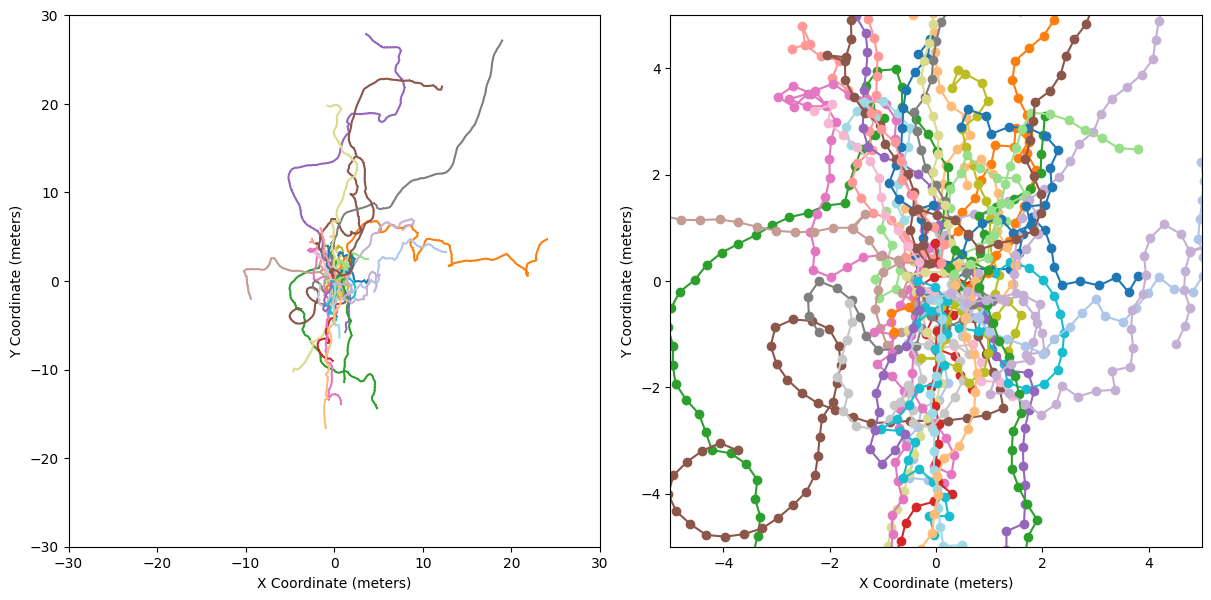

In [7]:
animal_ids = list(merged_df['animal_id'].unique())

# Use a colormap to assign a unique color to each trajectory
colors = plt.cm.tab20.colors  # Use a colormap with 20 distinct colors
# Create a figure with two subplots: one zoomed out and one zoomed in
fig, axs = plt.subplots(1, 2, figsize=(12, 10), constrained_layout=True)

# Use a colormap to assign a unique color to each trajectory
colors = plt.cm.tab20.colors  # Use a colormap with 20 distinct colors

# Iterate over animal IDs to plot their trajectories
for idx, animal_id in enumerate(animal_ids):
    # Filter the DataFrame for the current locust's trajectory
    individual_df = merged_df[merged_df['animal_id'] == animal_id]

    # Plot zoomed out view (-30 to 30) on the first subplot
    axs[0].plot(individual_df['X'], individual_df['Y'], marker=',', linestyle='-', color=colors[idx % 20])
    axs[0].set_xlim(-30, 30)
    axs[0].set_ylim(-30, 30)
    axs[0].set_xlabel('X Coordinate (meters)')
    axs[0].set_ylabel('Y Coordinate (meters)')
    axs[0].set_aspect(1)

    # Plot zoomed in view (-5 to 5) on the second subplot
    axs[1].plot(individual_df['X'], individual_df['Y'], marker='o', linestyle='-', color=colors[idx % 20])
    axs[1].set_xlim(-5, 5)
    axs[1].set_ylim(-5, 5)
    axs[1].set_xlabel('X Coordinate (meters)')
    axs[1].set_ylabel('Y Coordinate (meters)')
    axs[1].set_aspect(1)

# Show the plots
plt.show()



### Model Definition: Hierarchical Bimodal von Mises Mixture Model

To model the periodic, potentially bimodal directional movement patterns of locusts, we employ a hierarchical bimodal von Mises mixture model. This model captures both population-level (shared) and individual-specific directional patterns, while ensuring the parameters remain within reasonable bounds through appropriately chosen priors and link functions.

#### Individual-Level Likelihood

The likelihood for an observation $y$ from individual $i$ is given by a bimodal von Mises mixture distribution:

$$
p(y | i) = p(y | \Theta_i) = p(y | \boldsymbol{\mu}_i, \boldsymbol{\kappa}_i, \omega_i) = \frac{1}{Z(\boldsymbol{\kappa}_i, \omega_i)}\left[\omega_i \exp(\kappa_{i,1} \cos{(\mu_{i,1} - y)}) + (1 - \omega_i) \exp(\kappa_{i,2} \cos{(\mu_{i,2} - y)})\right]
$$

where:
- $p(y | i)$ corresponds to `directions_obs` in the code, representing the likelihood for any observation $y$ for individual $i$.
- $\Theta_i = \{ \boldsymbol{\mu}_i, \boldsymbol{\kappa}_i, \omega_i \}$ is the set of parameters for individual $i$.
- $\omega_i$ (corresponding to `weights[i]` in the code) is the mixture weight for the two directional modes of individual $i$, with $\omega_i \in [0, 1]$.
- $\boldsymbol{\mu}_i = \{\mu_{i,1}, \mu_{i,2}\}$ (coded as `mu[i]`) is the vector of mean directions for the two components, with $\mu_{i,j} \in [-\pi, \pi]$.
- $\boldsymbol{\kappa}_i = \{\kappa_{i,1}, \kappa_{i,2}\}$ (coded as `kappa[i]`) represents the concentration parameters (inverse variance) for each component, ensuring $\kappa > 0$.
- $Z(\boldsymbol{\kappa}_i, \omega_i)$ is the normalizing constant:

$$
Z(\boldsymbol{\kappa}_i, \omega_i) = \frac{\omega_i}{2 \pi I_0(\kappa_{i,1})} + \frac{(1 - \omega_i)}{2 \pi I_0(\kappa_{i,2})}
$$

where $I_0$ is the modified Bessel function of the first kind (order zero).

### Observations and Dataset Structure

In this model:
- $Y = \{Y_1, Y_2, \ldots, Y_N\}$ is the full dataset, where $N$ is the total number of individuals.
- Each $Y_i = \{y_{[i,1]}, y_{[i,2]}, \ldots, y_{[i,M_i]}\}$ represents the set of observations for individual $i$, where $M_i$ is the total number of observations for individual $i$.
- Each $y_{[i,j]}$ is a single observation for individual $i$, where $j$ indexes the observations within their set $Y_i$.

The likelihood for the entire dataset $Y$ is then the product of the likelihoods for all observations:
$$
p(Y | \Theta) = \prod_{i=1}^N \prod_{j=1}^{M_i} p(y_{[i,j]} | \Theta_i).
$$

This hierarchical structure allows the model to:
1. Capture **individual-specific patterns** from $Y_i$ for each individual $i$.
2. Share information across the population $Y$ to estimate population-level parameters while accounting for variability between individuals.

#### Hierarchical Structure: Sampling and Transformation

Individual-level parameters are modeled as deviations from population-level parameters, with the population-level parameters capturing shared trends and the offsets capturing individual-specific variability. These deviations and population-level parameters are sampled directly, and link functions are applied to ensure parameters are in their appropriate ranges.

1. **Mean Directions**:

   The individual-level mean directions $\boldsymbol{\mu}_i$ are computed as:

   $$\boldsymbol{\mu}_i = \boldsymbol{\mu}_0 + \delta(\boldsymbol{\mu}_i)$$

   where:
   - $\boldsymbol{\mu}_0$ is the population-level mean direction, sampled with a uniform prior over $[-\pi, \pi]$.
   - $\delta(\boldsymbol{\mu}_i)$ is the individual-specific offset, sampled from a Von Mises prior centered at 0.

   The mean directions $\boldsymbol{\mu}_i$ are constrained to the range $[-\pi, \pi]$ through the choice of these priors. Since no link function is required, the offsets are simply:

   $$\delta(\boldsymbol{\mu}_i) = \boldsymbol{\mu}_i - \boldsymbol{\mu}_0$$

2. **Concentration Parameters**:

   The individual-level concentration parameters $\boldsymbol{\kappa}_i$ are computed as:

   $$\boldsymbol{\kappa}_i = \varphi\big(\varphi^{-1}(\boldsymbol{\kappa}_0) + \delta_\varphi(\boldsymbol{\kappa}_i)\big)$$

   where:
   - $\boldsymbol{\kappa}_0$ is the population-level concentration parameter, sampled on the inverse-softplus scale.
   - $\delta_\varphi(\boldsymbol{\kappa}_i)$ is the individual-specific offset, sampled as a Gaussian deviation on the inverse-softplus scale.
   - $\varphi(x)$ is the softplus function, defined as $\varphi(x) = \log(1 + e^x)$, ensuring positivity of $\boldsymbol{\kappa}_i$.

   The offsets for $\boldsymbol{\kappa}_i$ are defined as:

   $$\delta_\varphi(\boldsymbol{\kappa}_i) = \varphi^{-1}(\boldsymbol{\kappa}_i) - \varphi^{-1}(\boldsymbol{\kappa}_0)$$

3. **Mixture Weights**:

   The individual-level mixture weights $\omega_i$ are computed as:

   $$\omega_i = \sigma\big(\sigma^{-1}(\omega_0) + \delta_\sigma(\omega_i)\big)$$

   where:
   - $\omega_0$ is the population-level mixture weight, sampled on the logit (inverse sigmoid) scale.
   - $\delta_\sigma(\omega_i)$ is the individual-specific offset, sampled as a Gaussian deviation on the logit scale.
   - $\sigma(x)$ is the sigmoid function, defined as $\sigma(x) = \frac{1}{1 + e^{-x}}$, ensuring $\omega_i \in [0, 1]$.

   The offsets for $\omega_i$ are defined as:

   $$\delta_\sigma(\omega_i) = \sigma^{-1}(\omega_i) - \sigma^{-1}(\omega_0)$$

By defining the individual-level parameters in terms of population-level parameters and offsets, this hierarchical structure enables flexible modeling of individual-specific variability while ensuring the parameters are in valid domains.

#### Priors

Priors in this model serve two purposes:
1. **Constraining the Model**: Priors define a reasonable range of parameterizations for the likelihood, ensuring the model does not explore implausible regions of the parameter space.
2. **Regularization**: Priors help prevent the model from being overly influenced by extreme or outlier data, stabilizing estimates and improving generalization.

The following priors are specified for the population and individual parameters:
- $\boldsymbol{\mu}_{0} \sim \text{Uniform}(-\pi, \pi)$, coded as `mu_pop_unsorted`, which is then sorted for model identifiability.
- $\varphi^{-1}(\boldsymbol{\kappa}_{0}) \sim \mathcal{N}(\varphi^{-1}(2), 0.5)$, specified as `kappa_log_pop`.
- $\sigma^{-1}(\omega_{0}) \sim \mathcal{N}(0, 0.5)$, specified as `weights_logit_pop`.
- $\delta(\boldsymbol{\mu}_i) \sim \text{VonMises}(0, 20)$, coded as `mu_unsorted`.
- $\delta_\varphi(\boldsymbol{\kappa}_i) \sim \mathcal{N}(0, 0.5)$, coded as `kappa_log`.
- $\delta_\sigma(\omega_i) \sim \mathcal{N}(0, 1.0)$, coded as `weights_logit`.

#### Importance of Hierarchical Parameterization

In studies where data are imbalanced across individuals, such as in modeling locust movement patterns, a hierarchical approach is essential for robust parameter estimation. Imbalanced sampling occurs when some individuals contribute significantly more data than others, which can lead to biased parameter estimates if individual data are either treated independently (no pooling) or fully combined (complete pooling). Hierarchical models address this issue by integrating both population-level and individual-specific effects, providing a principled framework to handle data imbalance.

#### Motivation for Hierarchical Models

When modeling repeated measurements across individuals, three approaches can be used to parameterize the model:

1. **No Pooling**: Each individual is treated independently, with their own set of parameters, $\Theta_i = \{\mu_i, \kappa_i, \omega_i\}$. While this method captures individual variability, it often leads to overfitting, particularly when data are sparse for some individuals.
2. **Complete Pooling**: All measurements are combined, ignoring individual identity, and modeled with a single shared set of parameters, $\Theta_0 = \{\mu_0, \kappa_0, \omega_0\}$. This approach assumes no individual variability, leading to biased estimates when individuals differ significantly.
3. **Partial Pooling**: Measurements are modeled using shared population-level parameters, $\Theta_0$, with individual-specific offsets, $\Theta_i = \Theta_0 + \delta(\Theta_i)$. This approach balances individual variability with group-level trends, allowing shared information to improve estimates for under-sampled individuals while preserving meaningful variability for well-sampled ones.

Among these, partial pooling is the most effective because it stabilizes parameter estimates for individuals with limited data (through shrinkage toward population-level parameters) while maintaining flexibility to capture individual-specific effects. This balance avoids overfitting for sparsely sampled individuals and underfitting for well-sampled ones, leading


In [8]:
# Define the data based on merged_df
directions = merged_df['direction'].values
individuals = merged_df['animal_id'].values.astype(np.int32)
num_individuals = merged_df['animal_id'].nunique()

def inverse_softplus(x):
    return pt.log(pt.exp(x) - 1)

# Define the model
with pm.Model() as hierarchical_directional_model:

    # Population mean angle in radians, bounded between -π and π
    mu_pop_unsorted = pm.Uniform("mu_pop_unsorted", lower=-np.pi, upper=np.pi, shape=(2,))
    mu_pop = pm.Deterministic("mu_pop", pt.sort(mu_pop_unsorted))

    # Individual mean angles with a Von Mises distribution, adjusted by the population mean
    mu_unsorted = pm.VonMises("mu_unsorted", mu=0, kappa=20, shape=(num_individuals, 2)) + mu_pop_unsorted
    mu = pm.Deterministic("mu", pt.sort(mu_unsorted))

    # Population kappa values with a softplus transformation for non-negativity
    kappa_log_pop = pm.Normal("kappa_log_pop", mu=inverse_softplus(2.0), sigma=0.5, shape=(2,))
    kappa_pop = pm.Deterministic("kappa_pop", pt.softplus(kappa_log_pop))

    # Individual kappa values, also transformed for non-negativity
    kappa_log = pm.Normal("kappa_log", mu=0, sigma=0.5, shape=(num_individuals, 2)) + kappa_log_pop
    kappa = pm.Deterministic("kappa", pt.softplus(kappa_log))

    # Population weights with a sigmoid transformation
    weights_logit_pop = pm.Normal("weights_logit_pop", mu=0, sigma=0.5)
    weights_pop = pm.Deterministic("weights_pop", pm.math.sigmoid(pt.stack([weights_logit_pop, -weights_logit_pop], axis=-1)))

    # Individual weights, also transformed with a sigmoid function
    weights_logit = pm.Normal("weights_logit", mu=0, sigma=1.0, shape=(num_individuals,)) + weights_logit_pop
    weights = pm.Deterministic("weights", pm.math.sigmoid(pt.stack([weights_logit, -weights_logit], axis=-1)))

    # Von Mises components for mixture model
    components = pm.VonMises.dist(mu=mu[individuals], kappa=kappa[individuals])

    # Mixture model for observed data (directions)
    pm.Mixture("directions_obs", w=weights[individuals], comp_dists=components, observed=directions)


### Model Sampling

To estimate the posterior distribution of the model parameters, we perform Bayesian sampling within the `hierarchical_directional_model` context. This involves running multiple independent Markov Chain Monte Carlo (MCMC) chains using the No-U-Turn Sampler (NUTS), a variant of Hamiltonian Monte Carlo (HMC). Running multiple chains ensures robust exploration of the parameter space and helps diagnose convergence.

#### The Posterior Distribution:
The posterior distribution of the model parameters, $ \Theta $, given the observed dataset $ Y $, is expressed as:
$$
p(\Theta \mid Y) = \frac{p(Y \mid \Theta) \cdot p(\Theta)}{p(Y)}
$$
where:
- $ p(Y \mid \Theta) $: The likelihood, quantifying how well the parameters $ \Theta $ explain the observed dataset $ Y $.
- $ p(\Theta) $: The prior distribution, which constrains the model to reasonable parameterizations of the likelihood and regularizes it to avoid overreacting to extreme or outlier data.
- $ p(Y) $: The marginal likelihood, a normalizing constant ensuring the posterior is a valid probability distribution. It is not computed directly in MCMC methods as it does not influence the sampling process.

Instead of directly calculating the posterior, we sample from it using MCMC. Specifically, we generate samples:
$$
\Theta \sim p(\Theta \mid Y),
$$
where $ p(\Theta \mid Y) $ is proportional to $ p(Y \mid \Theta) \cdot p(\Theta) $ (ignoring the normalizing constant $ p(Y) $). These samples approximate the posterior and allow us to estimate quantities like means, variances, and credible intervals.

#### Why Use Sampling?
Direct computation of the posterior distribution is often infeasible due to the high-dimensional integration required to calculate the marginal likelihood $ p(Y) $. Sampling methods like MCMC approximate the posterior by generating a representative set of samples from it. This bypasses the need for explicit computation of $ p(Y) $, making the approach computationally viable even for complex models.

#### Why Use Multiple Chains?
Running multiple MCMC chains is critical for:
1. **Exploration**: Ensuring adequate coverage of the parameter space by starting each chain from different initial points.
2. **Convergence Diagnostics**: Comparing multiple chains provides insight into whether the sampling process has converged to the posterior distribution. Diagnostics like R-hat are used to assess this.

#### The Role of NUTS:
The No-U-Turn Sampler automates key aspects of Hamiltonian Monte Carlo:
- **Efficient Exploration**: Avoids redundant trajectories, ensuring the parameter space is efficiently covered.
- **Adaptivity**: Automatically adjusts step sizes and trajectory lengths to optimize sampling performance.

#### Implementation Details:
1. **Warning Suppression**:
   - Sampling may generate non-critical `UserWarning` messages, which we suppress using:
     ```python
     warnings.catch_warnings()
     warnings.simplefilter("ignore", UserWarning)
     ```
   - This keeps output clean while ensuring the results remain unaffected.

2. **Sampling with PyMC**:
   - We use the `pm.sample` function to draw samples:
     - Specify the NUTS sampler for efficient sampling.
     - Request 1000 samples per chain for sufficient coverage.
     - Set `return_inferencedata=True` to store the results as an `InferenceData` object for diagnostics and visualization with `arviz`.

#### Outcome:
The result is a set of posterior samples (a "trace") for the model parameters:
$$
\{\Theta_1, \Theta_2, \ldots, \Theta_N\} \sim p(\Theta \mid Y),
$$
where $ p(\Theta \mid Y) \propto p(Y \mid \Theta) \cdot p(\Theta) $. These samples represent plausible parameterizations of the likelihood constrained and regularized by the prior. They are used for tasks such as parameter estimation, model checking, and prediction.


In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    with hierarchical_directional_model:
        trace = pm.sample(1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_pop_unsorted, mu_unsorted, kappa_log_pop, kappa_log, weights_logit_pop, weights_logit]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
/home/jake/.local/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### R-hat Diagnostic Check

The R-hat statistic, or potential scale reduction factor, evaluates the convergence of Markov Chain Monte Carlo (MCMC) simulations by comparing the variance between chains ($ \text{Var}_B $) and within chains ($ \text{Var}_W $).

#### Original Gelman-Rubin Diagnostic:
The original R-hat formula is:
$$
\hat{R} = \sqrt{\frac{\frac{n-1}{n} \text{Var}_W + \frac{1}{n} \text{Var}_B}{\text{Var}_W}}
$$
where $ n $ is the number of iterations per chain. Historically, R-hat values below 1.1 were considered acceptable for convergence. Further refinements suggested 1.05 as a stricter threshold for more robust results.

#### Rank-normalized R-hat:
The rank-normalized R-hat extends the original by rank-transforming samples before computing variances, making it more robust to outliers and skewed or long-tailed distributions. The improved method adopts a stricter convergence threshold:
- **Modern Threshold**: $ \hat{R} < 1.01 $ is now the recommended standard for convergence.

This update ensures more reliable assessments of convergence. For details, see Vehtari et al., 2021 ([arXiv:1903.08008](https://arxiv.org/abs/1903.08008)).

#### Excluding "Unsorted" Parameters:
Parameters labeled as "unsorted," such as unordered latent variables, can produce artificially inflated R-hat values due to chain-switching artifacts. These should be excluded during diagnostics and sorted versions of these parameters used in their place.

#### Why It Matters:
R-hat values are critical for confirming that MCMC chains have converged to the target posterior distribution. The shift to rank-normalized R-hat and a stricter threshold reflects advancements in diagnostic techniques, providing greater confidence in Bayesian model inferences.


In [10]:
def check_rhat(trace, lower=0.999, upper=1.01):
    """
    Checks if all R-hat values in the trace are within the specified range, excluding "unsorted" parameters.

    Parameters:
        trace: The trace from a PyMC sampling (InferenceData or similar).
        lower (float): The lower bound for acceptable R-hat values (default is 0.999).
        upper (float): The upper bound for acceptable R-hat values (default is 1.01).

    Returns:
        True if all R-hat values are within the range; otherwise, a dictionary with parameter names and R-hat values outside the range.
    """
    # Compute the R-hat values using ArviZ
    rhat_values = az.rhat(trace)
    
    # Initialize a dictionary to store parameters that are outside the acceptable range
    outside_params = {}

    # Iterate through each parameter and check its R-hat value, skipping "unsorted" parameters
    for var_name, values in rhat_values.data_vars.items():
        if "unsorted" in var_name:
            continue  # Skip this parameter

        # Convert each value to a NumPy array for easier handling
        rhat_arr = values.values
        
        # Check if any R-hat values are outside the range for this parameter
        mask_outside_range = (rhat_arr < lower) | (rhat_arr > upper)
        
        # If any values are out of range, add them to the dictionary with their indices
        if mask_outside_range.any():
            outside_params[var_name] = rhat_arr[mask_outside_range]

    # If no parameters are outside the range, return True; otherwise, return the dictionary
    if not outside_params:
        return True
    else:
        return outside_params


# Define acceptable R-hat range
rhat_min = 0.999
rhat_max = 1.01

# Check R-hat values after sampling
result = check_rhat(trace, lower=rhat_min, upper=rhat_max)
if result is True:
    display(Markdown(f"# ✅ All R-hat values are within the acceptable range\n**({rhat_min} < R-hat < {rhat_max}), excluding unsorted parameters.**"))
else:
    display(Markdown(f"# ⚠️ The following parameters have R-hat values outside the acceptable range ({rhat_min} < R-hat < {rhat_max}):"))
    for param, rhat_values in result.items():
        display(Markdown(f"## - {param}: **R-hat values = {rhat_values}**"))


# ✅ All R-hat values are within the acceptable range
**(0.999 < R-hat < 1.01), excluding unsorted parameters.**

### Effective Sample Size (ESS) Diagnostic Check

After verifying convergence with R-hat, it is also essential to assess the efficiency and reliability of the posterior samples. This is done by evaluating the Effective Sample Size (ESS). ESS measures how many independent samples the Markov Chain Monte Carlo (MCMC) process effectively provides and is a critical diagnostic for ensuring robust inference.

#### ESS Components:
ESS is computed for two regions of the posterior distribution:
- **Bulk-ESS**: Evaluates sampling efficiency for the central (bulk) portion of the distribution.
- **Tail-ESS**: Evaluates sampling efficiency for the tails of the distribution.

Both are necessary to confirm that the MCMC process has thoroughly explored all regions of the posterior.

#### ESS Threshold:
A commonly used threshold is 400, indicating adequate sampling. Values below this threshold may suggest:
- Poor mixing of the chains.
- Insufficient exploration of certain regions, potentially leading to biased estimates.

#### Excluding "Unsorted" Parameters:
Parameters labeled with `"unsorted"` are excluded from the diagnostic to avoid artifacts caused by chain-switching or parameter ambiguity.

#### Function Overview:
1. **Computation**:
   - Bulk-ESS and Tail-ESS are computed using ArviZ for all parameters.
2. **Threshold Check**:
   - ESS values are compared against the specified threshold.
   - Parameters with ESS values below the threshold are flagged.
3. **Output**:
   - If all ESS values meet the threshold, the function returns `True`.
   - Otherwise, it returns a dictionary listing parameters with low Bulk-ESS or Tail-ESS values.

#### Execution:
After running the function `check_ess_bulk_tail`, the results are examined:
- **All ESS Above Threshold**: A confirmation message is printed.
- **ESS Below Threshold**: Parameters with low Bulk-ESS or Tail-ESS values are flagged and reported for further inspection.

By checking ESS after confirming convergence with R-hat, we ensure that the posterior samples are both reliable and sufficient for robust Bayesian inference and downstream analyses.


In [11]:
def check_ess_bulk_tail(trace, threshold=400):
    """
    Checks if both Bulk-ESS and Tail-ESS meet the specified threshold,
    excluding parameters with "unsorted" in their names.

    Parameters:
        trace: The trace from PyMC sampling (InferenceData or similar).
        threshold (int): Minimum acceptable ESS value for both bulk and tail (default is 400).

    Returns:
        True if all Bulk-ESS and Tail-ESS values meet the threshold; otherwise,
        a dictionary with parameter names and values below the threshold.
    """
    # Compute Bulk-ESS and Tail-ESS using ArviZ
    ess_bulk = az.ess(trace, method="bulk")
    ess_tail = az.ess(trace, method="tail")

    # Initialize dictionaries to store parameters with ESS below the threshold
    below_bulk_threshold = {}
    below_tail_threshold = {}

    # Check Bulk-ESS values
    for var_name, values in ess_bulk.data_vars.items():
        if "unsorted" in var_name:
            continue  # Skip parameters with "unsorted" in their names

        ess_arr = values.values
        mask_below_threshold = ess_arr < threshold
        if mask_below_threshold.any():
            below_bulk_threshold[var_name] = ess_arr[mask_below_threshold]

    # Check Tail-ESS values
    for var_name, values in ess_tail.data_vars.items():
        if "unsorted" in var_name:
            continue  # Skip parameters with "unsorted" in their names

        ess_arr = values.values
        mask_below_threshold = ess_arr < threshold
        if mask_below_threshold.any():
            below_tail_threshold[var_name] = ess_arr[mask_below_threshold]

    # Combine results
    if not below_bulk_threshold and not below_tail_threshold:
        return True
    else:
        return {
            "bulk_ess_below_threshold": below_bulk_threshold,
            "tail_ess_below_threshold": below_tail_threshold,
        }

# Check Bulk-ESS and Tail-ESS values after sampling
ess_result = check_ess_bulk_tail(trace, threshold=400)
if ess_result is True:
    display(Markdown("# ✅ All Bulk-ESS and Tail-ESS values are above the acceptable threshold of 400.\n**(Excluding unsorted parameters)**"))
else:
    if ess_result["bulk_ess_below_threshold"]:
        display(Markdown("# ⚠️ The following parameters have Bulk-ESS values below the acceptable threshold:"))
        for param, ess_values in ess_result["bulk_ess_below_threshold"].items():
            display(Markdown(f"## - {param}: **Bulk-ESS values = {ess_values}**"))

    if ess_result["tail_ess_below_threshold"]:
        display(Markdown("# ⚠️ The following parameters have Tail-ESS values below the acceptable threshold:"))
        for param, ess_values in ess_result["tail_ess_below_threshold"].items():
            display(Markdown(f"## - {param}: **Tail-ESS values = {ess_values}**"))


# ✅ All Bulk-ESS and Tail-ESS values are above the acceptable threshold of 400.
**(Excluding unsorted parameters)**

### Model Evaluation: Comparing Posterior Predictive Density with Non-Parametric Estimates

The goal of this section is to evaluate the model fit by comparing the **posterior predictive density** obtained from the Bayesian hierarchical model with **non-parametric estimates** of the density at the population level. We employ multiple methods to compare estimated density of locust movement across directions, including:

- **Posterior Predictive Density**: Using the posterior estimates from the hierarchical model to compute the overall directional density.
- **Bootstrapped Histogram Estimates**: Non-parametric bootstrap sampling to approximate the mean density for each directional bin.
- **Von Mises Kernel Density Estimates (KDE)**: Using a Von Mises kernel to estimate the density smoothly over the entire circle.

This comparison helps us visually and quantitatively assess how well the hierarchical model captures the population-level directional tendencies of locusts.

#### Population-Level Mixture Model for Posterior Predictive Density

To calculate the posterior predictive density, we use the **population-level parameter vector** $\Theta_0 = \{\omega_0, \boldsymbol{\kappa}_0, \boldsymbol{\mu}_0\}$, where:
- $\omega_0$ (coded as `weights_pop`) represents the mixture weight for the two directional modes,
- $\boldsymbol{\kappa}_0 = \{\kappa_{0,1}, \kappa_{0,2}\}$ (coded as `kappa_pop`) are the concentration parameters for each mode, controlling the spread around the means,
- $\boldsymbol{\mu}_0 = \{\mu_{0,1}, \mu_{0,2}\}$ (coded as `mu_pop`) are the directional means for the two modes.

The **posterior predictive density** for a given angle $y$ using the population-level parameters is then:

$$
p(y \mid \Theta_0) = \frac{1}{Z(\boldsymbol{\kappa}_0, \omega_0)} \left[ \omega_0 \exp \left( \kappa_{0,1} \cos (\mu_{0,1} - y) \right) + (1 - \omega_0) \exp \left( \kappa_{0,2} \cos (\mu_{0,2} - y) \right) \right]
$$

where:
- $Z(\boldsymbol{\kappa}_0, \omega_0)$ is the normalizing constant:

$$
Z(\boldsymbol{\kappa}_0, \omega_0) = \frac{\omega_0}{2\pi I_0(\kappa_{0,1})} + \frac{(1 - \omega_0)}{2\pi I_0(\kappa_{0,2})}
$$

with $I_0(\kappa)$ being the modified Bessel function of the first kind (order zero), ensuring that $p(y \mid \Theta_0)$ integrates to 1 over the circle.

**Why Do We Need a Parametric Model When We Have Non-Parametric Estimates?**

Non-parametric methods, such as the bootstrapped histogram and the Von Mises KDE, are flexible because they make minimal assumptions about the underlying data distribution. However, this flexibility comes at the cost of requiring a large number of parameters—essentially one for each data point—and thus, they often provide detailed numerical representations rather than compact, interpretable summaries of the data. Non-parametric methods excel at estimating observed distributions directly but lack **parsimony**—the ability to offer a simplified, generalized model that can be easily interpreted or used for predictions.

Moreover, non-parametric approaches can present challenges for **structured inference**. Because they lack a pre-defined framework, they can be less straightforward to interpret and apply to infer underlying processes. They are also **sensitive to sample size**; with limited data, non-parametric estimates can become noisy and less reliable, while a parametric model, with its structured assumptions, can offer a more robust representation even with sparse data.

Another limitation of non-parametric methods is that they require **hyperparameters that are not directly estimated from the data**, such as bin width in histograms or kernel concentration in KDEs. Choosing these hyperparameters often involves tuning, adding complexity to the modeling process and potentially introducing subjectivity.

In contrast, a **parametric model** like a hierarchical Bayesian model learns all of its parameters directly from the data. This approach is more parsimonious, offering a structured and interpretable summary of the underlying processes. A hierarchical model can **generalize** effectively, enabling us to understand both individual-level and population-level tendencies and to make predictions about new data.

To ensure the parametric model accurately captures the population-level statistics, we use non-parametric methods, such as bootstrapped estimates, to validate the model’s fit. By comparing the non-parametric estimates with the predictions from the parametric model, we can check for alignment between the two approaches. This alignment provides confidence that the parametric model is capturing essential aspects of the data’s structure while maintaining interpretability, robustness, and the ability to uncover underlying trends in locust movement.

### Evaluate Log Probability of Mixture of Von Mises Distributions Across Angles

This notebook defines a log probability evaluation function for a mixture of Von Mises distributions, parameterized by posterior samples (`mu_pop`, `kappa_pop`, and `weights_pop`). The key steps are as follows:

1. **Extract Posterior Samples**:
   - Samples for `mu_pop`, `kappa_pop`, and `weights_pop` are reshaped for compatibility with broadcasting requirements.

2. **Define Angle Range**:
   - A range of 360 angles is defined, evenly spaced from $-\pi$ to $\pi$ for evaluation.

3. **Compile Log Probability Function**:
   - The function uses `pm.compile_pymc` for efficient evaluation.
   - Broadcasting is used to handle posterior samples and angles simultaneously.

4. **Evaluate Log Probabilities**:
   - The compiled function is applied to the range of angles.
   - Percentiles (2.5%, 50%, 97.5%) summarize posterior density.
   - Log probabilities are converted to probabilities for visualization.

The outputs are ready for visualization and allow for comparison with other density estimates.


In [12]:
# Extract posterior samples for population-level parameters
posterior = trace["posterior"]

# Define the angles as a tensor vector for input
angles = pt.vector('angles')

def compile_logp_fn(mu, kappa, weights):
    """
    Compiles a log probability evaluation function for a mixture of Von Mises distributions.
    
    Parameters:
    ----------
    mu : ndarray
        Mean directions of the Von Mises components (posterior samples).
    kappa : ndarray
        Concentration parameters of the Von Mises components (posterior samples).
    weights : ndarray
        Mixture weights for the components (posterior samples).
    
    Returns:
    -------
    function
        A compiled function to evaluate the log probability of the mixture model for given angles.
    """
    # Create Von Mises components, adding extra dimension for broadcasting
    components = pm.VonMises.dist(mu=mu[:, None], kappa=kappa[:, None])
    
    # Define the mixture model using weights and the Von Mises components
    directions_mixture = pm.Mixture.dist(w=weights[:, None], comp_dists=components)
    
    # Compute the log probability over the vector of angles, broadcasting shapes as needed
    logp = pm.logp(directions_mixture, angles[None, :])
    
    # Compile the log probability function for efficient evaluation
    return pm.compile_pymc([angles], logp)

# Compile the function using the posterior samples for the population-level parameters
logp_fn = compile_logp_fn(posterior["mu_pop"].values.reshape(-1, 2),
                          posterior["kappa_pop"].values.reshape(-1, 2),
                          posterior["weights_pop"].values.reshape(-1, 2))

# Define a numpy array of angles from -π to π for evaluation
angle_values = np.linspace(-np.pi, np.pi, 360).astype(np.float64)

# Evaluate the compiled log probability function across all angles
logp_values = logp_fn(angle_values)

# Compute percentiles (2.5%, 50%, 97.5%) of the log probabilities across posterior samples
logp_lower, logp_median, logp_upper = np.percentile(logp_values, [2.5, 50, 97.5], axis=0)

# Convert log probabilities to densities for visualization
density_lower, density_median, density_upper = np.exp(logp_lower), np.exp(logp_median), np.exp(logp_upper)

### Hierarchical Bootstrapping

Hierarchical bootstrapping is a resampling method used to estimate metrics while accounting for variability within and across sampling units (e.g., individual animals). Instead of treating all data points as independent, this method resamples at the level of the sampling unit, preserving the nested structure of the data. It is especially useful when observations are grouped by identifiable units, ensuring that the variability both within and across units is incorporated into the estimation.

#### Steps in Hierarchical Bootstrapping

For data grouped by sampling units, where each unit has a set of observations $Y_i = \{y_{[i,1]}, y_{[i,2]}, \dots, y_{[i, M_i]}\}$:

1. **Resampling Within Units**:
   - For each bootstrap iteration:
     - Resample data from each sampling unit with replacement:
       $$
       Y_i^* = \{y_{[i, 1]}^*, y_{[i, 2]}^*, \dots, y_{[i, M_i]}^*\}, \quad y_{[i, j]}^* \sim Y_i.
       $$

2. **Metric Computation for Each Unit**:
   - Apply a computation function $f$ to the resampled data for each unit:
     $$
     f(Y_i^*).
     $$

3. **Aggregating Across Units**:
   - Combine results from all units for a single bootstrap iteration. For example, compute the average across sampling units:
     $$
     \bar{f}_b = \frac{1}{N} \sum_{i=1}^N f(Y_i^*),
     $$
     where $N$ is the number of sampling units, and $\bar{f}_b$ is the aggregated result for bootstrap iteration $b$.

4. **Summarizing Bootstrap Iterations**:
   - After completing multiple bootstrap iterations ($B$ total), summarize the results:
     - Median:
       $$
       \text{Median} = \text{Percentile}_{50\%} \{\bar{f}_1, \bar{f}_2, \dots, \bar{f}_B\}.
       $$
     - Confidence intervals:
       $$
       \text{CI}_{2.5\%, 97.5\%} = \left[\text{Percentile}_{2.5\%}, \text{Percentile}_{97.5\%}\right] \{\bar{f}_1, \bar{f}_2, \dots, \bar{f}_B\}.
       $$

This general process is adaptable to a wide variety of computation functions $f$, depending on the metric of interest.

---

### Bootstrapped Histogram Density Estimate

When applying hierarchical bootstrapping to compute histograms, the computation function $f$ calculates the density in predefined bins for the resampled data. This method provides a piecewise constant estimate of density across directional bins, where each bin spans a range of directions.

#### Additional Details for Histogram Computation

1. **Histogram as the Metric Function**:
   - For each resampled dataset $Y_i^*$, compute a normalized histogram:
     $$
     \sum_{k=1}^K h_i^*(k) \cdot \Delta_k = 1,
     $$
     where $h_i^*(k)$ is the density in bin $k$, and $\Delta_k$ is the bin width.

2. **Aggregating Across Units**:
   - For each bootstrap iteration, compute the mean density across all individuals for each bin:
     $$
     \bar{h}_b(k) = \frac{1}{N} \sum_{i=1}^N h_i^*(k),
     $$
     where $k$ indexes the bins, and $N$ is the number of sampling units.

3. **Summarizing Across Bootstrap Iterations**:
   - After all bootstrap iterations, calculate:
     - **Median density** for each bin:
       $$
       \text{Median}(k) = \text{Percentile}_{50\%} \{\bar{h}_{1}(k), \bar{h}_{2}(k), \dots, \bar{h}_{B}(k)\}.
       $$
     - **Confidence intervals** for each bin:
       $$
       \text{CI}_{2.5\%, 97.5\%}(k) = \left[\text{Percentile}_{2.5\%}, \text{Percentile}_{97.5\%}\right] \{\bar{h}_{1}(k), \bar{h}_{2}(k), \dots, \bar{h}_{B}(k)\}.
       $$

By using histogram bins as the computation function, the hierarchical bootstrap framework generates a density estimate that accounts for the variability both within and across sampling units.

---

### Code Implementation

1. **Hierarchical Bootstrap Framework**:
   - Implemented in the `hierarchical_bootstrap` function, which handles resampling and applies the metric function.

2. **Histogram Computation**:
   - The `bootstrap_histogram` function calculates normalized histograms for resampled data and aggregates across bootstrap iterations.

3. **Result Summarization**:
   - The `bootstrap_summary_stats` function computes the median density and confidence intervals for each histogram bin.

---

### Output

The final output includes:
- **Median density values** for each histogram bin, representing the central tendency of directional density.
- **Confidence intervals** for each bin, quantifying the variability in density across bootstrap samples.

This application of hierarchical bootstrapping to histograms provides a straightforward, non-parametric density estimate tailored to the structure of the data.


In [13]:
def hierarchical_bootstrap(data, labels, compute_func, n_bootstraps=4000, n_jobs=-1):
    """
    General hierarchical bootstrapping function with optional parallelization.

    Parameters:
    ----------
    data : array-like
        Array of data to bootstrap.
    labels : array-like
        Array of individual labels corresponding to the data.
    compute_func : callable
        Function to apply to the bootstrapped data. It should take an array of data and return the result.
    n_bootstraps : int, optional
        Number of bootstrap iterations (default is 4000).
    n_jobs : int, optional
        Number of jobs to run in parallel. Default is -1 (use all processors).

    Returns:
    -------
    np.ndarray
        Array of bootstrapped results, one per iteration.
    """
    unique_labels = np.unique(labels)

    def single_bootstrap():
        iteration_results = []
        weights = []
        for label in unique_labels:
            # Data for this individual
            individual_data = data[labels == label]
            
            # Bootstrap sample
            bootstrapped_sample = np.random.choice(individual_data, size=len(individual_data), replace=True)
            
            # Apply the computation function
            result = compute_func(bootstrapped_sample)
            iteration_results.append(result)
            

        iteration_results = np.array(iteration_results)

        # Aggregate results
        return np.mean(iteration_results, axis=0)

    # Parallelize the bootstrapping process
    bootstrap_results = Parallel(n_jobs=n_jobs)(delayed(single_bootstrap)() for _ in tqdm(range(n_bootstraps), desc="Bootstrapping"))

    return np.array(bootstrap_results)

@jit(nopython=True)
def histogram(data_sample, bins):
    """
    Compute histogram using Numba with normalization.

    Parameters:
    ----------
    data_sample : array-like
        Data sample to compute the histogram for.
    bins : array-like
        Bin edges for the histogram.

    Returns:
    -------
    np.ndarray
        Histogram counts normalized to density.
    """
    n_bins = len(bins) - 1
    hist = np.zeros(n_bins)

    for value in data_sample:
        for i in range(n_bins):
            if bins[i] <= value < bins[i + 1]:
                hist[i] += 1
                break
        # Include the rightmost edge case
        if value == bins[-1]:
            hist[-1] += 1

    # Normalize to density
    bin_widths = np.diff(bins)
    hist = hist / (np.sum(hist) * bin_widths)

    return hist

def bootstrap_summary_stats(bootstrap_samples, axis=0, lower=2.5, upper=97.5):
    """
    Compute summary statistics (median and confidence intervals) from bootstrap samples.

    Parameters:
    ----------
    bootstrap_samples : array-like
        Bootstrap samples. The shape and interpretation depend on the application.
        For example, in a histogram context, this might be (n_bootstraps x n_bins).
    axis : int, optional
        Axis along which to compute the statistics (default is 0).
    lower : float, optional
        Lower percentile for the confidence interval (default is 2.5).
    upper : float, optional
        Upper percentile for the confidence interval (default is 97.5).

    Returns:
    -------
    dict
        Contains:
        - 'median': Median values along the specified axis.
        - 'lower_bounds': Lower bounds of the confidence interval.
        - 'upper_bounds': Upper bounds of the confidence interval.
        - 'errors': Tuple of errors ([median - lower_bounds], [upper_bounds - median]).
    """
    if lower >= upper:
        raise ValueError("`lower` must be less than `upper`.")

    # Compute required percentiles
    percentiles_values = np.percentile(bootstrap_samples, [lower, 50, upper], axis=axis)
    lower_bounds, median, upper_bounds = percentiles_values

    # Calculate errors
    errors = np.array([median - lower_bounds, upper_bounds - median])
    
    return {
        'median': median,
        'lower_bounds': lower_bounds,
        'upper_bounds': upper_bounds,
        'errors': errors
    }

def bootstrap_histogram(data, labels, n_bins=16, n_bootstraps=4000):
    """
    Bootstrap histograms for directional data with hierarchical sampling.

    Parameters:
    ----------
    data : array-like
        Array of directional data (angles in radians).
    labels : array-like
        Array of individual labels corresponding to the data.
    n_bins : int, optional
        Number of bins for the histogram (default is 16).
    n_bootstraps : int, optional
        Number of bootstrap iterations (default is 4000).

    Returns:
    -------
    dict
        Contains:
        - 'bootstrap_histograms': Bootstrap distribution of mean histograms (n_bootstraps x n_bins).
        - 'bin_centers': Array of bin centers.
    """
    # Ensure data is in the range [-π, π]
    data = (data + np.pi) % (2 * np.pi) - np.pi

    # Define bins and bin centers
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # # Define histogram computation function
    # def compute_histogram(data_sample):
    #     hist, _ = np.histogram(data_sample, bins=bins, density=True)
    #     return hist
    # Define histogram computation function
    def compute_histogram(data_sample):
        return histogram(data_sample, bins=bins)

    
    # Perform hierarchical bootstrapping
    bootstrap_histograms = hierarchical_bootstrap(data, labels, compute_histogram, n_bootstraps)

    return {
        'bootstrap_histograms': bootstrap_histograms,
        'bin_centers': bin_centers
    }

# Example directional data and labels
directions = merged_df['direction'].values
labels = merged_df['animal_id'].values

# Compute bootstrap histograms
bootstrap_results = bootstrap_histogram(directions, labels, n_bins=16, n_bootstraps=4000)

# Compute summary statistics
summary_stats = bootstrap_summary_stats(bootstrap_results['bootstrap_histograms'])

# Access results
hist_bin_centers = bootstrap_results['bin_centers']
hist_median = summary_stats['median']
hist_lower_bounds = summary_stats['lower_bounds']
hist_upper_bounds = summary_stats['upper_bounds']
hist_errors = summary_stats['errors']


Bootstrapping:   0%|          | 0/4000 [00:00<?, ?it/s]

### Bootstrapped Von Mises Kernel Density Estimate (KDE)

This method computes a **Von Mises Kernel Density Estimate (KDE)** to provide a smooth, continuous estimate of directional density using hierarchical bootstrapping. Instead of using histogram bins, the KDE smooths the density across all angles using a Von Mises kernel, which is well-suited for circular data. Each sampling unit (e.g., individual animals) contributes its resampled data to the final estimate.

---

### Steps in Bootstrapped Von Mises KDE

Using the hierarchical bootstrapping framework:

1. **Von Mises KDE Computation**:
   - For each resampled dataset from a sampling unit, compute the KDE at a series of evaluation points $\{\theta_1, \theta_2, \dots, \theta_K\}$ using the Von Mises kernel:
     $$
     d_i(\theta_k) = \frac{1}{M_i} \sum_{j=1}^{M_i} \frac{\exp(\kappa \cos(\theta_k - y_{[i, j]}))}{2 \pi I_0(\kappa)}, \quad k = 1, 2, \dots, K.
     $$
     - $M_i$: Number of observations for sampling unit $i$.
     - $\kappa$: Concentration parameter controlling the smoothness of the kernel. Larger $\kappa$ results in less smoothing.
     - $I_0(\kappa)$: Modified Bessel function of the first kind for normalizing the kernel.

2. **Aggregating Across Sampling Units**:
   - For each bootstrap iteration, compute the mean KDE across all sampling units:
     $$
    \bar{d}_b(\theta_k) = \frac{1}{N} \sum_{i=1}^N d_i(\theta_k), \quad k = 1, 2, \dots, K,
     $$
     where $N$ is the number of sampling units.

3. **Summarizing Across Bootstraps**:
   - After all bootstrap iterations, summarize the density at each evaluation point $\theta_k$:
     - **Median Density**:
       $$
       \text{Median}(\bar{d}(\theta_k)) = \text{Percentile}_{50\%} \{ \bar{d}_1(\theta_k),\bar{d}_2(\theta_k), \dots,\bar{d}_B(\theta_k)\}.
       $$
     - **Confidence Intervals**:
       $$
       \text{CI}_{2.5\%, 97.5\%}(\bar{d}(\theta_k)) = \left[\text{Percentile}_{2.5\%}, \text{Percentile}_{97.5\%}\right]\{ \bar{d}_1(\theta_k),\bar{d}_2(\theta_k), \dots,\bar{d}_B(\theta_k)\}.
       $$

---

### Code Implementation

1. **Von Mises Kernel Density Function**:
   - The `von_mises_kde` function calculates the kernel density at specified points using the Von Mises distribution.

2. **Bootstrap KDE Function**:
   - The `bootstrap_von_mises_kde` function applies hierarchical bootstrapping, computing KDEs for each bootstrap iteration and aggregating the results across all sampling units.

3. **Result Summarization**:
   - The `bootstrap_summary_stats` function computes the median density and confidence intervals for the KDE at each evaluation point.

---

### Output

The final output includes:
- **Median density values** for each evaluation point, representing the smooth central estimate of directional density.
- **Confidence intervals** for each point, reflecting variability due to differences within and across sampling units.

This approach provides a continuous density estimate, offering a smoother alternative to histogram-based density estimation while retaining the structure of the data.


In [14]:
def von_mises_kde(data, points, kappa):
    """
    Compute the Von Mises kernel density estimate (KDE) at given points.

    Parameters:
    ----------
    data : array-like
        Input data (angles in radians). Each value should be within the range [-π, π].
    points : array-like
        Points at which to evaluate the KDE (angles in radians).
    kappa : float
        Concentration parameter of the Von Mises distribution, controlling the "peakiness".

    Returns:
    -------
    np.ndarray
        KDE values evaluated at the input points. Each value represents the estimated density
        at the corresponding point.
    
    Notes:
    -----
    - This function uses vectorized operations for efficient computation.
    - The kernel density is computed by averaging the Von Mises kernel values across the data,
      where the kernel is defined as exp(kappa * cos(point - data)).
    """
    c = 1 / (2 * np.pi * i0(kappa))
    cos_diffs = np.cos(points[:, None] - data)
    exp_vals = np.exp(kappa * cos_diffs)
    return c * exp_vals.mean(axis=1)

def bootstrap_von_mises_kde(data, labels, kappa, n_bootstraps=4000, n_points=360):
    """
    Computes bootstrapped Von Mises KDE estimates using hierarchical bootstrapping.

    Parameters:
    ----------
    data : array-like
        Input data (angles in radians).
    labels : array-like
        Individual labels corresponding to the data.
    kappa : float
        Concentration parameter of the Von Mises distribution.
    n_bootstraps : int, optional
        Number of bootstrap iterations (default is 4000).
    n_points : int, optional
        Number of points to evaluate the KDE (default is 360).

    Returns:
    -------
    dict
        Contains:
        - 'bootstrap_kdes': Bootstrap distribution of KDE results (n_bootstraps x n_points).
        - 'angles': Array of angles where the KDE is evaluated.
    """
    # Ensure data is in the range [-π, π]
    data = (data + np.pi) % (2 * np.pi) - np.pi

    # Define points for KDE evaluation
    angles = np.linspace(-np.pi, np.pi, n_points)

    # Define KDE computation function for hierarchical bootstrapping
    def compute_kde(bootstrapped_sample):
        return von_mises_kde(bootstrapped_sample, angles, kappa)

    # Perform hierarchical bootstrapping
    bootstrap_kdes = hierarchical_bootstrap(data, labels, compute_kde, n_bootstraps)

    return {
        'bootstrap_kdes': bootstrap_kdes,
        'angles': angles
    }

# Reuse the `bootstrap_summary_stats` function from before for KDE summary statistics
# Example usage:
directions = merged_df['direction'].values
labels = merged_df['animal_id'].values

n_points = 360
kappa = 30.0
bootstrap_kde_results = bootstrap_von_mises_kde(directions, labels, kappa=kappa, n_points=n_points)

summary_stats = bootstrap_summary_stats(bootstrap_kde_results['bootstrap_kdes'])

# Access results
kde_angles = bootstrap_kde_results['angles']
kde_median = summary_stats['median']
kde_lower_bounds = summary_stats['lower_bounds']
kde_upper_bounds = summary_stats['upper_bounds']


Bootstrapping:   0%|          | 0/4000 [00:00<?, ?it/s]

### Visualization of Model Evaluation

This step visualizes the **posterior predictive density** and compares it to the **non-parametric bootstrap estimates**:

1. **Plotting Setup**:
   - The figure is divided into two subplots (`ax1` and `ax2`) to compare the posterior predictive density with the histogram and KDE estimates.
   - Several plot adjustments are made to improve the aesthetics (e.g., tick width, font size, and removing the top and right spines).
2. **Posterior Predictive Density**:
   - The **posterior predictive density** is plotted with its 95% credible interval, using red lines and filled regions (`prob_25`, `prob_50`, `prob_75`).
3. **Bootstrapped Histogram**:
   - The median density estimate from the bootstrapped histogram is plotted on `ax1` with error bars representing the 95% confidence interval.
4. **Bootstrapped KDE**:
   - The **Von Mises KDE** median and its 95% confidence interval are plotted on `ax2`, using a dashed line and filled area.
5. **Custom Legend**:
   - A custom legend is created using a custom handler to represent the posterior, histogram, and KDE lines clearly.
6. **Labels and Saving**:
   - Shared x-axis labels, figure title, and shared y-axis labels are added to clarify the plot.
   - The plot can be saved in various formats (`.svg`, `.pdf`, `.png`) for further use.

This visual comparison provides a comprehensive evaluation of the hierarchical model's fit to the population-level locust movement data. By using both histogram and KDE non-parametric estimates, we can see the agreement (or discrepancies) between model-based and data-driven density estimates.


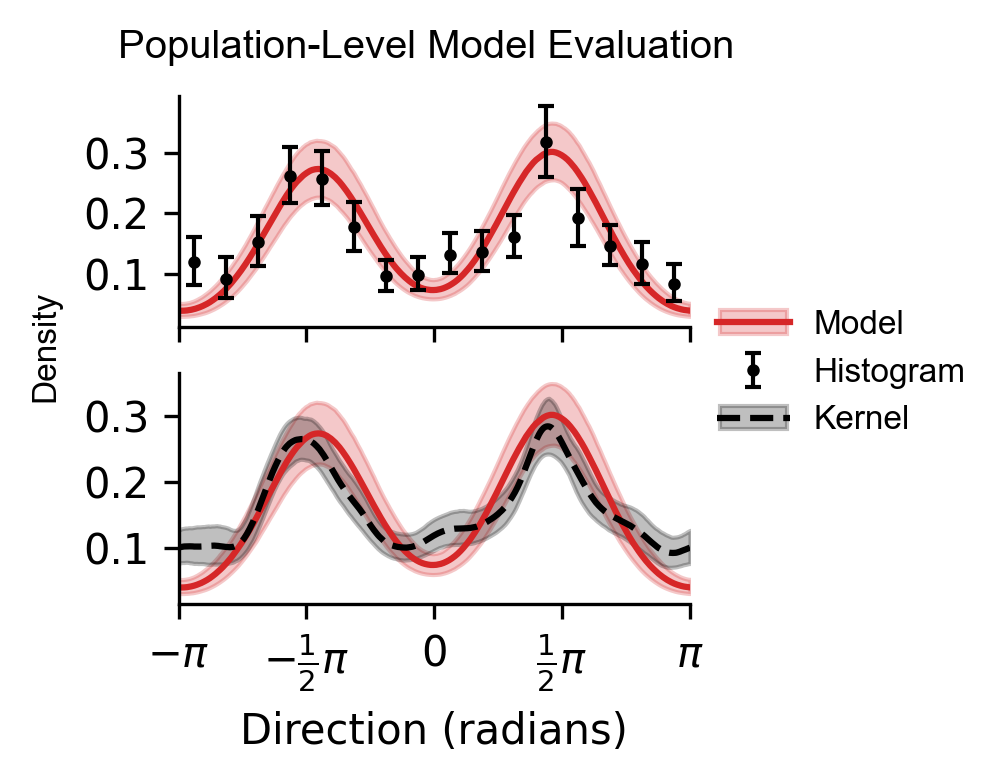

In [15]:
# Custom legend handler
def customer_handler(color, linestyle=None):
    class HandlerLineInPatch(mlegend_handler.HandlerBase):
        def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans, ):
            # Create a patch as the background
            patch = mpatches.Rectangle(xy=(-xdescent, -ydescent), width=width, height=height, color=color, alpha=0.25, transform=trans)
            
            # Create a line across the center of the patch
            line = mlines.Line2D([-0.05*width, 1.05*width], [0.5*height, 0.5*height], color=color, transform=trans + legend.get_transform(), linestyle=linestyle)
            
            return [patch, line]
    return HandlerLineInPatch()

# Assume bin_centers, median, errors, angles, density_median, density_lower, density_upper are already defined
# Plot adjustments as per Sercan's request
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(1.1*2, 1.1 * 2), sharex=True, dpi=300)
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 8})


angles = np.linspace(-np.pi, np.pi, n_points)

# Posterior Density line and fill
for ax in [ax1, ax2]:
    line_plot, = ax.plot(angles, density_median, 'tab:red', label='Posterior Density')
    fill_plot = ax.fill_between(angles, density_lower, density_upper, color='tab:red', alpha=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


fill_plot_kde = ax2.fill_between(kde_angles, kde_lower_bounds, kde_upper_bounds, color='black', alpha=0.25)
line_plot_kde, = ax2.plot(kde_angles, kde_median, label='Median KDE', color="black", linestyle="--")

# # Error bars for the median
errorbar_plot = ax1.errorbar(hist_bin_centers, hist_median, yerr=hist_errors, fmt='o', ecolor='black', 
             markeredgecolor='black', markerfacecolor='black', linewidth=1, capsize=2, 
             markersize=2, label="Bootstrap Density\n(Median ± 95% C.I.)")

ax2.set_xlabel('Direction (radians)')
ax2.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r"$-\pi$", r"$-\frac{1}{2}\pi$", r"0", r"$\frac{1}{2}\pi$", r"$\pi$"])

plt.xlim(-np.pi, np.pi)
fig.suptitle('Population-Level Model Evaluation')
# Creating a shared y-label
fig.text(-0.1, 0.5, 'Density', va='center', rotation='vertical')  # Adjust these coordinates as needed


# Creating the legend with both individual and combined entries
plt.legend([line_plot, errorbar_plot, line_plot_kde, ], 
           ["Model", "Histogram", "Kernel"],
           handler_map={line_plot_kde: customer_handler("black", "--"), line_plot: customer_handler("tab:red")},
           bbox_to_anchor=(1, 1), frameon=False, loc="center left")

# plt.savefig("./locust_directional_validation.svg", bbox_inches="tight")
# plt.savefig("./locust_directional_validation.pdf", bbox_inches="tight")
# plt.savefig("./locust_directional_validation.png", bbox_inches="tight", dpi=300)

plt.show()


### Visualization of Population-Level Model Evaluation

This plot visualizes the **posterior predictive density** alongside **non-parametric bootstrap estimates** and a **kernel density estimate (KDE)** in a polar coordinate system:

1. **Plotting Setup**:
   - A polar plot is used to represent the density estimates, capturing the directional nature of the data.
   - Plot aesthetics, such as line thickness, font size, and axis labels, are tailored for clarity and consistency.

2. **Posterior Predictive Density**:
   - The **posterior predictive density median** is shown as a red line, while the **95% credible interval** is highlighted with a shaded red region.
   - This illustrates the model's central tendency and uncertainty in directional predictions.

3. **Kernel Density Estimate (KDE)**:
   - The **KDE median** is represented as a dashed black line, and its **95% confidence interval** is shown with a lighter shaded region, offering a non-parametric comparison to the model.

4. **Bootstrapped Density Estimate**:
   - Bootstrapped median estimates are displayed as black markers with error bars, indicating the **95% confidence interval** for the density at specific angular bins.

5. **Visual Enhancements**:
   - A circular outline serves as a visual reference for the plot boundaries, ensuring clarity in interpreting density variations.
   - Polar spines are removed to make the plot cleaner, focusing attention on the data.

6. **Custom Legend**:
   - A tailored legend distinguishes between the posterior density, histogram-based estimates, and KDE, ensuring clear identification of plot components.

7. **Labels and Title**:
   - X-axis ticks are customized to reflect angles in radians (`-π` to `π`), aligning with the directional nature of the data.
   - The plot is titled **"Population-Level Model Evaluation"**, summarizing the purpose of the visualization.

This polar plot provides a comprehensive comparison of the model-based and data-driven density estimates, emphasizing the directional characteristics of the population-level data. It allows for clear assessment of model fit and alignment with observed patterns, leveraging both parametric and non-parametric methods.


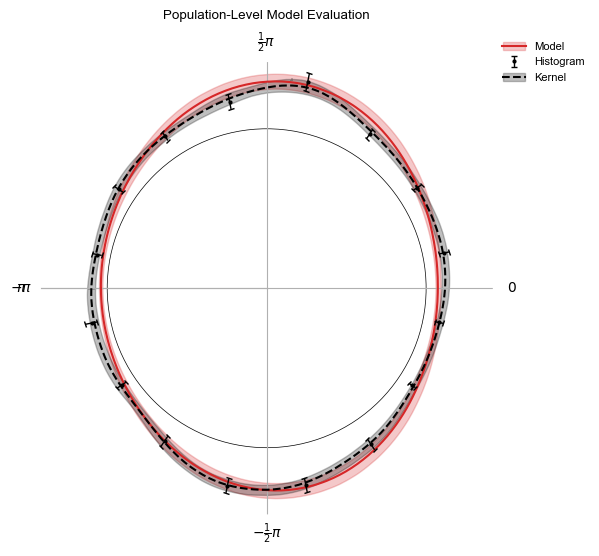

In [16]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 8})
edge_radius = 1.0

# Compute the mean of posterior samples for each individual
mu_mean = posterior["mu_pop"].mean(dim=["chain", "draw"]).values  
weights_mean = posterior["weights_pop"].mean(dim=["chain", "draw"]).values

# Plot the median of the posterior density as a red line
line_plot, = ax.plot(angles, edge_radius + density_median, color="tab:red", linewidth=1.5, label="Posterior Predictive Density Median")

# Fill between lower and upper bounds of the density estimates
ax.fill_between(angles, edge_radius + density_lower, edge_radius + density_upper, color="tab:red", alpha=0.25, label="95% C.I.")

# Add circular outline for visual reference
outer_circle = Circle((0, 0), edge_radius, transform=ax.transData._b, color="black", fill=False, linewidth=0.5)
ax.add_artist(outer_circle)

# Add kernel density estimate (KDE) as dashed black line
line_plot_kde, = ax.plot(kde_angles, edge_radius + kde_median, color="black", linestyle="--", linewidth=1.5, label="Kernel Density Estimate Median")

# Fill between KDE lower and upper bounds in a lighter shade
ax.fill_between(kde_angles, edge_radius + kde_lower_bounds, edge_radius + kde_upper_bounds, color='black', alpha=0.25, label="KDE 95% C.I.")

errorbar_plot = ax.errorbar(hist_bin_centers, edge_radius + hist_median, yerr=[(hist_median + edge_radius) - (hist_lower_bounds + edge_radius), (hist_upper_bounds + edge_radius) - (hist_median + edge_radius)], fmt='o', ecolor='black', 
             markeredgecolor='black', markerfacecolor='black', linewidth=1, capsize=2, 
             markersize=2, label="Bootstrap Density\n(Median ± 95% C.I.)")

# Set plot limits and labels
ax.set_ylim(0, edge_radius + np.max(density_upper) * 1.2)
ax.set_xlim(-np.pi, np.pi)
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_xticklabels([r"$- \pi$", r"$-\frac{1}{2}\pi$", r"$0$", r"$\frac{1}{2}\pi$", r"$\pi$"], fontsize=10)
ax.set_yticks([])

# Remove the default polar frame to make the plot cleaner
ax.spines['polar'].set_visible(False)

# Set the title for the population-level plot
ax.set_title('Population-Level Model Evaluation', va='bottom')

# Add legend with customized handler if needed
# Creating the legend with both individual and combined entries
plt.legend([line_plot, errorbar_plot, line_plot_kde], 
           ["Model", "Histogram", "Kernel"],
           handler_map={line_plot_kde: customer_handler("black", "--"), line_plot: customer_handler("tab:red")},
           bbox_to_anchor=(1, 1), frameon=False, loc="center left")

# Save the figure if needed
# plt.savefig("population_directional_validation.svg", bbox_inches="tight")
# plt.savefig("population_directional_validation.pdf", bbox_inches="tight")
# plt.savefig("population_directional_validation.png", bbox_inches="tight", dpi=300)

plt.tight_layout()
plt.show()


### Individual-Level Directional Predictive Check with Observed Data, Mode Weights, and Residuals

After assessing the population-level parameters, we now examine individual-level estimates within this hierarchical model. This plot compares the posterior predictive distribution (PDF) with observed data directions for each individual, with **arrows** indicating the mean directions of the model’s two modes, scaled by their respective **mean resultant vector lengths** and **mixture weights**. Additionally, the residuals are plotted to visually assess the agreement between the model and the observed data.

1. **Plot Components**:
   - **Posterior Predictive PDF**:
     - The predictive distribution is shown as a red line near the outer edge of each subplot, representing the model’s expected directional density for each individual based on the mean posterior parameters. Specifically, the predictive density for individual $i$ at angle $y$ can be represented as:

     $$
     p(y \mid \Theta_i) = \frac{1}{Z(\boldsymbol{\kappa}_i, \omega_i)} \left[ \omega_i \exp \left( \kappa_{i,1} \cos (\mu_{i,1} - y) \right) + (1 - \omega_i) \exp \left( \kappa_{i,2} \cos (\mu_{i,2} - y) \right) \right]
     $$

     where $ \omega_i $, $ \kappa_{i,j} $, and $ \mu_{i,j} $ are individual-level parameters for the mixture weight, concentration, and mean direction of each mode, respectively. In the code, these are represented as `weights_mean[i]`, `kappa_mean[i]`, and `mu_mean[i]` respectively, with $ Z(\boldsymbol{\kappa}_i, \omega_i) $ being the normalizing constant.

   - **Observed Data Vectors**:
     - Each observed direction is shown as a short blue line extending outward near the circle’s edge. These lines indicate observed angles without crowding the plot’s center.

2. **Mode Means**:
   - **Mean Directions of Each Mode**:
     - The posterior means of the two directional modes for each individual are represented as solid red arrows originating from the center and extending outward. The length of each arrow is scaled by:
       1. The **mean resultant vector length** ($ R_j $) derived from the concentration parameter $ \kappa_{i,j} $, reflecting the directional concentration of each mode.
       2. The **mixture weight** ($ \omega_{i,j} $), indicating the relative importance of each mode in the overall predicted distribution.
     - Specifically, the length $ L_{i,j} $ of the arrow for mode $ j $ is given by:

     $$
     L_{i,j} \propto \omega_{i,j} \cdot R_j
     $$

     This combined scaling ensures that the arrows not only indicate the direction of each mode but also visually encode their relative contribution and concentration in the model.

3. **Residuals**:
   - **Agreement Between Model and Observed Data**:
     - Residuals are calculated to measure the model's agreement with the observed data. The residuals are represented as green lines extending from the observed data points, with the length of each line indicating the **degree of disagreement** between the observed data and the model's predictive PDF. **Longer residuals suggest greater disagreement**, where the model does not accurately predict the observed direction, while shorter residuals indicate better agreement.
     - The residuals visually emphasize areas where the model performs well (short residuals) or poorly (long residuals), highlighting how well the model captures each individual’s observed data patterns.

4. **Interpretation**:
   - **Alignment with Observed Data**: Observed data vectors aligning with peaks in the posterior predictive PDF suggest that the model captures individual-level directional patterns effectively.
   - **Mode Weights and Concentrations**: The lengths of the mode mean arrows indicate each mode’s relative weight (mixture weight) and directional concentration (mean resultant vector length), providing insight into the contribution of each directional mode for each individual.
   - **Residuals**: The residuals help identify areas where the model disagrees with observed data. **Long residuals indicate strong model disagreement**, while shorter residuals suggest a good fit where the model closely predicts the observed directions.

This visualization is intended to reveal how well the model aligns with observed patterns at both individual and population levels, showing both the primary predicted directions, the relative weighting and concentration of each mode, and the degree of model agreement through residuals.


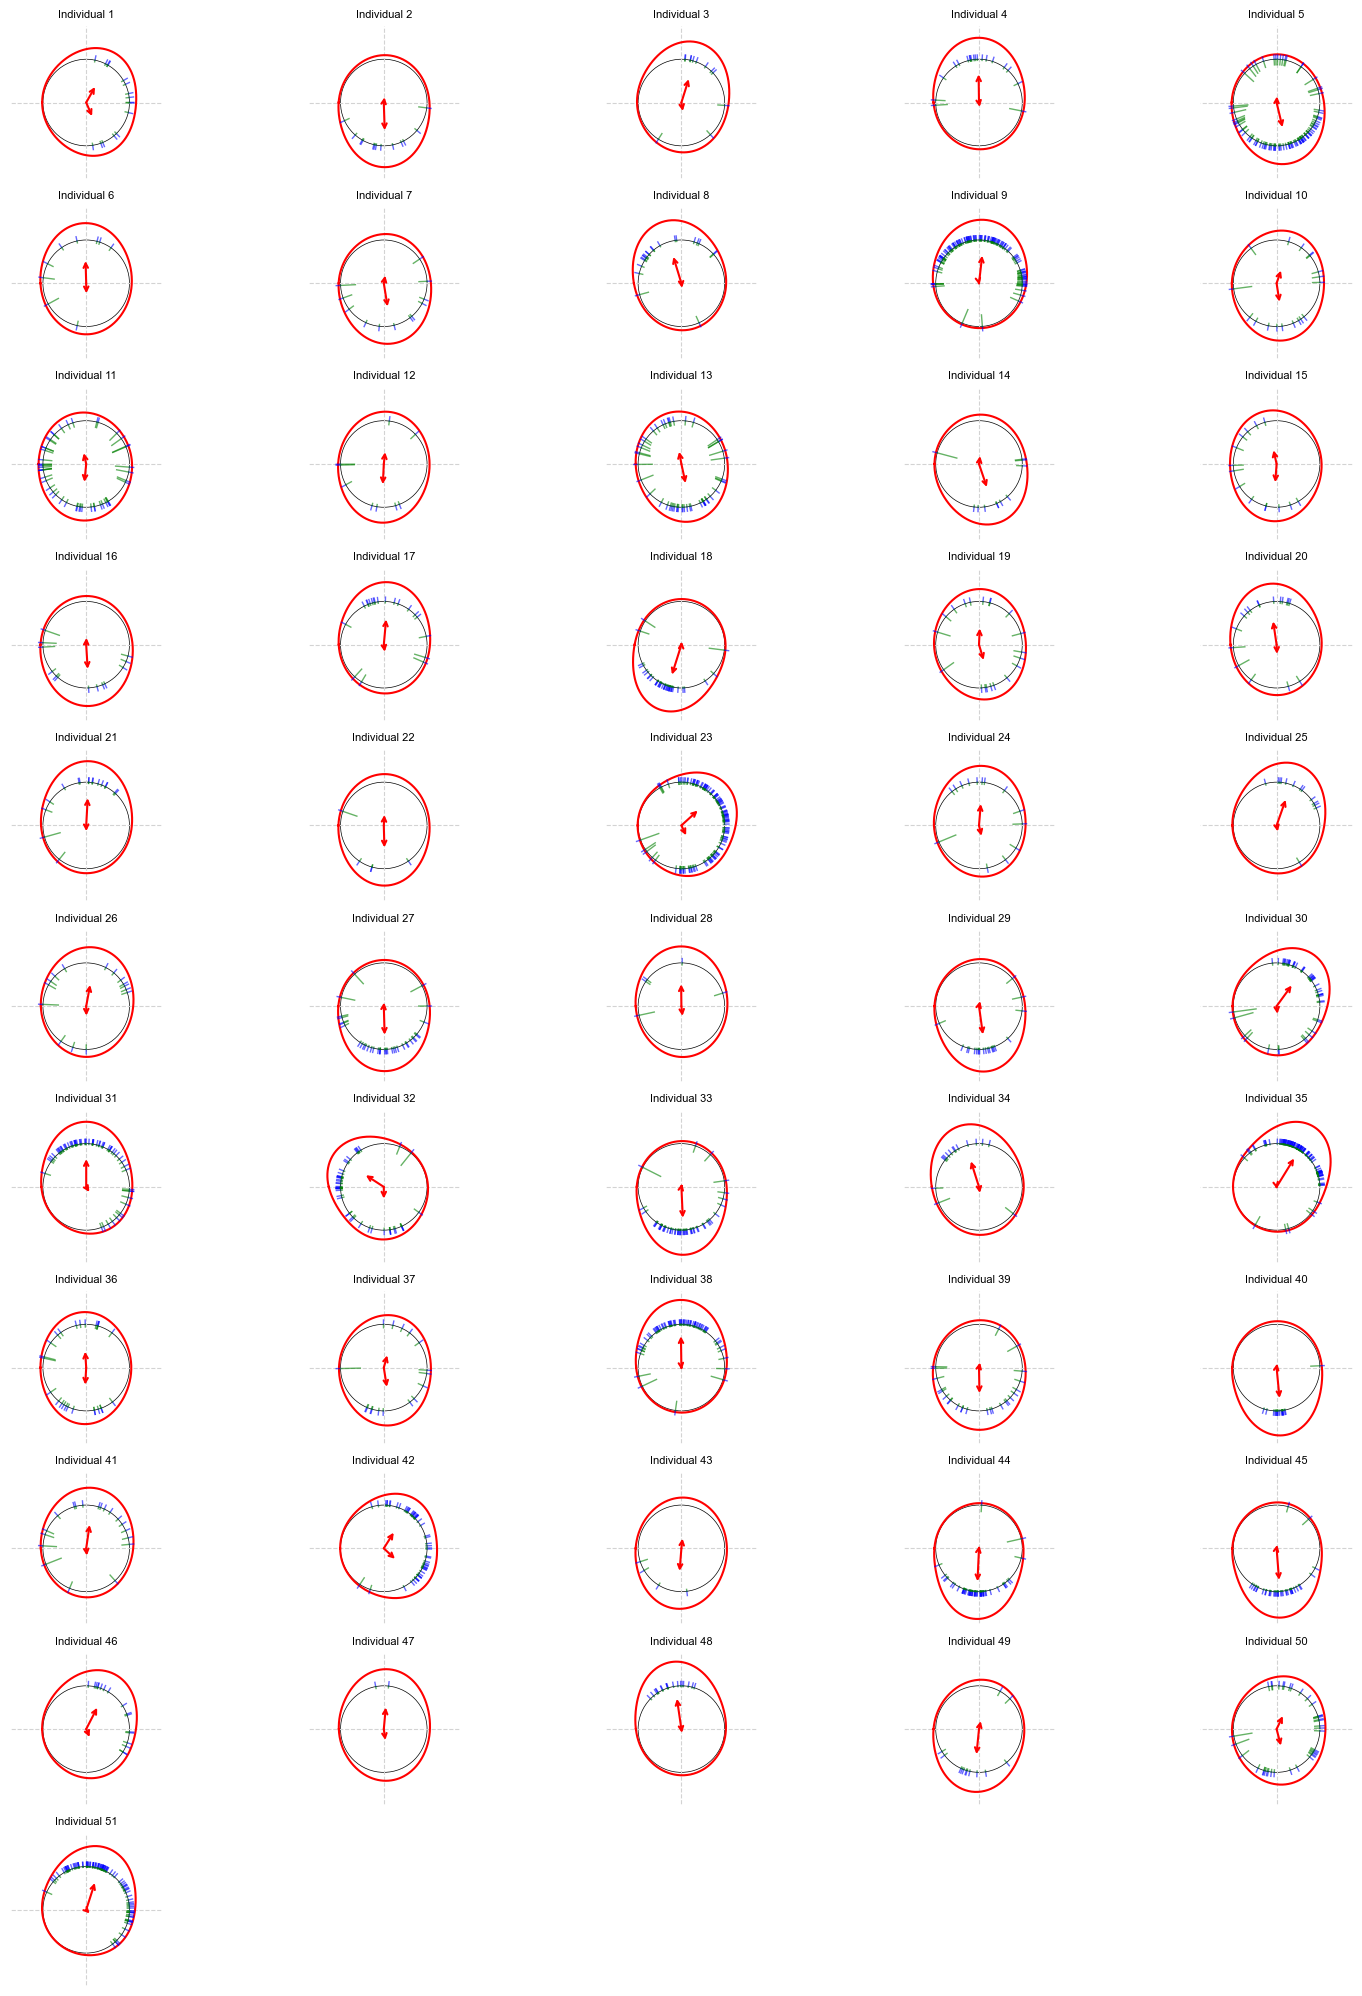

In [17]:
# Define the angle range for plotting PDFs
angles = np.linspace(-np.pi, np.pi, 360)

# Compute the mean of posterior samples for each individual
mu_mean = posterior["mu"].mean(dim=["chain", "draw"]).values  # Shape: (num_individuals, 2)
kappa_mean = posterior["kappa"].mean(dim=["chain", "draw"]).values  # Shape: (num_individuals, 2)
weights_mean = posterior["weights"].mean(dim=["chain", "draw"]).values  # Shape: (num_individuals, 2)

# Define the radius for plotting the PDFs and data vectors
edge_radius = 1.0

# Create a figure with subplots for each individual
fig, axs = plt.subplots(nrows=11, ncols=5, subplot_kw={'projection': 'polar'}, figsize=(15, 20))
axs = axs.flatten()

# Calculate the global maximum PDF value for consistent scaling
max_pdf_global = 0
for idx, individual in enumerate(np.unique(individuals)):
    # Extract the mean parameters for this individual
    mu_ind = mu_mean[idx]
    kappa_ind = kappa_mean[idx]
    weights_ind = weights_mean[idx]
    
    # Compute the mixture log-PDF across the full angle range
    log_component_1 = np.log(weights_ind[0]) + vonmises.logpdf(angles, kappa_ind[0], loc=mu_ind[0])
    log_component_2 = np.log(weights_ind[1]) + vonmises.logpdf(angles, kappa_ind[1], loc=mu_ind[1])
    log_pdf_values = np.logaddexp(log_component_1, log_component_2)
    pdf_values = np.exp(log_pdf_values)
    
    # Update the global maximum PDF value
    max_pdf_global = max(max_pdf_global, np.max(pdf_values))

# Plot the mixture PDF across the full angle range for normalization
for idx, individual in enumerate(np.unique(individuals)):

    # Add light gray lines for main angles (0 to π and π/2 to -π/2)
    axs[idx].plot([0, 0], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)
    axs[idx].plot([np.pi, np.pi], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)
    axs[idx].plot([np.pi / 2, np.pi / 2], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)
    axs[idx].plot([-np.pi / 2, -np.pi / 2], [0, edge_radius + max_pdf_global * 1.2], color="lightgray", linestyle="--", linewidth=0.8)

    individual_data = directions[individuals == individual]
    
    # Extract the mean parameters for this individual
    mu_ind = mu_mean[idx]
    kappa_ind = kappa_mean[idx]
    weights_ind = weights_mean[idx]
    
    # Compute the mixture log-PDF across the full angle range
    log_component_1 = np.log(weights_ind[0]) + vonmises.logpdf(angles, kappa_ind[0], loc=mu_ind[0])
    log_component_2 = np.log(weights_ind[1]) + vonmises.logpdf(angles, kappa_ind[1], loc=mu_ind[1])
    log_pdf_values = np.logaddexp(log_component_1, log_component_2)
    pdf_values = np.exp(log_pdf_values)

    # Calculate the inverted PDF across the full range and normalize
    inverted_pdf_values = np.exp(-log_pdf_values)
    normalization_factor = np.trapz(inverted_pdf_values, angles)  # Integrate over angles for normalization
    
    # Plot the averaged PDF as a red line around the outer edge
    axs[idx].plot(angles, edge_radius + pdf_values, color="red", linewidth=1.5, label="Posterior Predictive PDF")

    # Plot observed data as short radial lines
    line_length = 0.1  # Length of the lines for observed data
    for angle in individual_data:
        axs[idx].plot([angle, angle], [edge_radius, edge_radius + line_length], color="blue", alpha=0.6, linewidth=1)
    
    # Compute mean resultant vector lengths for each mode
    R1 = iv(1, kappa_ind[0]) / iv(0, kappa_ind[0])  # Mode 1
    R2 = iv(1, kappa_ind[1]) / iv(0, kappa_ind[1])  # Mode 2
    
    # Scale arrow lengths by mean resultant vector length and mixture weight
    arrow_length_1 = edge_radius * R1 * weights_ind[0]
    arrow_length_2 = edge_radius * R2 * weights_ind[1]
    
    # Plot arrows for mode means
    axs[idx].annotate(
        '', xy=(mu_ind[0], arrow_length_1), xytext=(0, 0),
        arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=1.5, shrinkA=0, shrinkB=0)
    )
    axs[idx].annotate(
        '', xy=(mu_ind[1], arrow_length_2), xytext=(0, 0),
        arrowprops=dict(facecolor='red', edgecolor='red', arrowstyle='->', lw=1.5, shrinkA=0, shrinkB=0)
    )

    # Calculate residuals for observed data using normalized inverted log-PDF values
    residual_angles = []
    for angle in individual_data:
        # Calculate the log-PDF value at the observed angle using log-sum-exp
        log_pdf_component_1 = np.log(weights_ind[0]) + vonmises.logpdf(angle, kappa_ind[0], loc=mu_ind[0])
        log_pdf_component_2 = np.log(weights_ind[1]) + vonmises.logpdf(angle, kappa_ind[1], loc=mu_ind[1])
        log_pdf_value = np.logaddexp(log_pdf_component_1, log_pdf_component_2)
        
        # Invert the log-PDF value in log-space
        inverted_log_pdf_value = -log_pdf_value
        
        # Convert back to regular scale for normalization and residual calculation
        inverted_pdf_value = np.exp(inverted_log_pdf_value)
        normalized_inverted_value = inverted_pdf_value / normalization_factor
    
        # Calculate residual as the difference between observed position and normalized inverted value
        residual = edge_radius - (edge_radius + normalized_inverted_value)
        residual_angles.append((angle, residual))
    
    # Plot residuals as short green lines extending from observed data points
    for angle, residual in residual_angles:
        axs[idx].plot([angle, angle], [edge_radius, edge_radius + residual], 
                      color="green", alpha=0.6, linewidth=1, linestyle='-', label="Residuals" if idx == 0 else "")
    
    # Add custom circular outline
    outer_circle = Circle((0, 0), edge_radius, transform=axs[idx].transData._b, color="black", fill=False, linewidth=0.5)
    axs[idx].add_artist(outer_circle)

    # Set plot limits and titles with global max PDF scaling
    axs[idx].set_ylim(0, edge_radius + max_pdf_global * 1.2)
    axs[idx].set_title(f"Individual {individual + 1}", fontsize=8)
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])

    # Remove the default polar frame
    axs[idx].spines['polar'].set_visible(False)
    

# Hide unused subplots
for ax in axs[len(np.unique(individuals)):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


### Hypothesis Testing: Posterior Likelihood of Movement Directions

In this section, we test two directional hypotheses for locust movement, comparing their likelihoods under the model to assess whether there is statistical evidence for directional preferences. These hypotheses correspond to potential mechanisms used by locusts to coordinate movement: **vectorial encoding** for perpendicular directions and **optic flow** for forward movement.

1. **Hypotheses**:
   - **Forward Direction Hypothesis** (Optic Flow): Locusts have a significant tendency to move in the forward direction ($y = 0$), possibly facilitated by optic flow processing.
   - **Perpendicular Directions Hypothesis** (Vectorial Encoding): Locusts show a significant tendency to move perpendicular to the forward direction ($y = \pm \frac{\pi}{2}$), potentially relying on vectorial encoding.
   - We compare these hypotheses to a **random walk baseline** represented by a uniform distribution, which assumes no directional bias.

#### Model Definition for Hypothesis Testing

Using the posterior samples, we construct the **population-level mixture model** that represents the directional tendencies across all locusts. This involves setting individual offsets to zero, effectively focusing on the average behavior captured by the **population-level parameter vector** $ \Theta_0 = \{\omega_0, \boldsymbol{\kappa}_0, \boldsymbol{\mu}_0\} $, where:
- $ \omega_0 $ (coded as `weights_pop`) represents the mixture weight for the two directional modes,
- $ \boldsymbol{\kappa}_0 = \{\kappa_{0,1}, \kappa_{0,2}\} $ (coded as `kappa_pop`) are the concentration parameters for each mode, controlling the spread around the means,
- $ \boldsymbol{\mu}_0 = \{\mu_{0,1}, \mu_{0,2}\} $ (coded as `mu_pop`) are the directional means for the two modes.

The **posterior predictive density** at a given angle $y$ for this model is represented as:

$$
p(y \mid \Theta_0) = \frac{1}{Z(\boldsymbol{\kappa}_0, \omega_0)} \left[ \omega_0 \exp \left( \kappa_{0,1} \cos (\mu_{0,1} - y) \right) + (1 - \omega_0) \exp \left( \kappa_{0,2} \cos (\mu_{0,2} - y) \right) \right]
$$

where:
- $ Z(\boldsymbol{\kappa}_0, \omega_0) $ is the normalizing constant:

$$
Z(\boldsymbol{\kappa}_0, \omega_0) = \frac{\omega_0}{2\pi I_0(\kappa_{0,1})} + \frac{(1 - \omega_0)}{2\pi I_0(\kappa_{0,2})}
$$

with $ I_0(\kappa) $ being the modified Bessel function of the first kind (order zero), ensuring that $ p(y \mid \Theta_0) $ integrates to 1 over the circle.

#### Hypothesis Testing Steps

1. **Random Walk Baseline (Uniform Distribution)**:
   - The random walk baseline is defined as a uniform distribution over the circle, with a constant density:

   $$
   p_{\text{uniform}} = \frac{1}{2\pi}
   $$

2. **Calculate Probabilities for Hypotheses**:
   - **Forward Direction Hypothesis**:
     - For the forward direction, we calculate the probability of the posterior mixture model at $ y = 0 $ radians, which we denote as $ p_{\text{forward}} $:

     $$
     p_{\text{forward}} = p(y = 0 \mid \Theta_0)
     $$

   - **Perpendicular Directions Hypothesis**:
     - For the perpendicular directions, we calculate the combined probability at $ y = \frac{\pi}{2} $ and $ y = -\frac{\pi}{2} $, which we denote as $ p_{\text{perpendicular}} $:

     $$
     p_{\text{perpendicular}} = \frac{1}{2} \left[ p(y = \frac{\pi}{2} \mid \Theta_0) + p(y = -\frac{\pi}{2} \mid \Theta_0) \right]
     $$

   This combined probability reflects the likelihood of movement in either perpendicular direction.

3. **Comparison Against the Random Walk Baseline**:
   - By comparing these posterior probabilities to the random walk baseline ($ p_{\text{uniform}} $), we assess whether the model supports a directional preference for either forward or perpendicular movement. This allows us to determine if locusts show statistically significant directional tendencies compared to random movement.

In summary, this hypothesis testing approach, leveraging the posterior predictive density, enables us to evaluate whether there is a statistically significant preference for specific movement directions in locusts when compared to a uniform, random-walk model.


In [18]:
posterior = trace["posterior"]

components = pm.VonMises.dist(
    mu=posterior["mu_pop"].values.reshape(-1, 2),
    kappa=posterior["kappa_pop"].values.reshape(-1, 2)
)

directions_mixture = pm.Mixture.dist(
    w=posterior["weights_pop"].values.reshape(-1, 2),
    comp_dists=components
)

p_forward = np.exp(pm.logp(directions_mixture, value=0).eval())

p_perp = (
    np.exp(pm.logp(directions_mixture, value=-np.pi / 2).eval() - np.log(2)) +
    np.exp(pm.logp(directions_mixture, value=np.pi / 2).eval() - np.log(2))
)
p_uniform = 1 / (2 * np.pi) 

#### Visualization of Hypothesis Testing Results

To visualize the results of the hypothesis testing, we create a violin plot to display the distribution of posterior likelihoods for the forward and perpendicular movement hypotheses.

1. **Plotting Setup**:
   - We plot the **posterior likelihoods** for both hypotheses (`p_forward` and `p_perp`) using a **violin plot**.
   - These likelihoods are exponentiated in the code and combined into a data structure (`DATA`) for plotting, making the values directly interpretable as probabilities.

2. **Violin Plot Customization**:
   - We use **Seaborn's `violinplot`** to visualize the distribution of posterior likelihoods for the two hypotheses.
   - Several aesthetic adjustments are made to improve clarity:
     - Adjusting tick and axis line widths,
     - Hiding the top and right spines for a cleaner look,
     - Setting the font to Arial for consistency.

3. **Adding Uniform Baseline**:
   - A dashed line is added at the **uniform baseline** (`p_uniform`), which represents the random walk baseline for comparison. This line shows the expected likelihood under a uniform distribution with no directional preference.
   - Comparing the posterior likelihoods against this baseline helps us assess if the observed directional tendencies are statistically significant.

4. **Custom Diagram Annotations**:
   - We add **custom diagrams** to visually indicate each directional hypothesis:
     - **Forward Direction**: A circle with an arrow pointing to the right, representing the forward movement hypothesis.
     - **Perpendicular Directions**: A circle with arrows pointing up and down, representing the perpendicular movement hypothesis.
   - These icons make the plot more intuitive by visually associating each plot element with the corresponding hypothesis.

5. **Displaying the Plot**:
   - The final plot is displayed, allowing a direct comparison of the posterior likelihood distributions for the forward and perpendicular hypotheses relative to the random walk baseline.
   
This visualization provides a clear way to compare the posterior likelihoods of the forward and perpendicular hypotheses, helping to reveal whether locusts exhibit statistically significant directional preferences in their movement patterns relative to a random movement model.


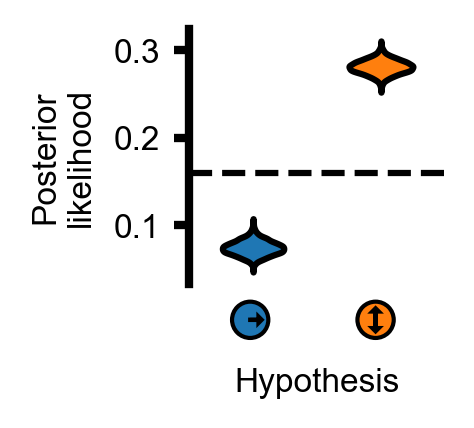

In [19]:
# Stack probabilities for plotting
DATA = np.stack([p_forward, p_perp], axis=-1)

plt.figure(figsize=(1.1, 1.1), dpi=300)
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 8})

ax = sns.violinplot(data=DATA, inner=None, cut=0, width=0.5, linecolor='black', edgecolor='black', saturation=1.0)

# Additional adjustments
# ax.set_xticklabels([""])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("Hypothesis", labelpad=20)
ax.set_ylabel("Posterior\nlikelihood")

# Hide the default tick labels
ax.set_xticklabels([])
ax.set_xticks([])
ax.axhline(p_uniform, ls='--', c='k', label="uniform")

for art in ax.collections:
    art.set_edgecolor('black')

fig = plt.gcf()
# Custom function to draw diagrams on the axis
def draw_diagram(ax, x, diagram_type):
    # Determine the position in figure space
    trans = ax.get_xaxis_transform() # This combines x in data units and y in axes fraction
    if diagram_type == "forward":
        # Draw circle with arrow pointing right
        ax.add_patch(Circle((x, 0), 0.055, clip_on=False, transform=fig.transFigure, edgecolor='black', facecolor='tab:blue'))
        ax.add_patch(FancyArrow(x, 0, 0.025, 0, clip_on=False, transform=fig.transFigure, head_width=0.02, head_length=0.01, edgecolor='black', facecolor='black'))
    elif diagram_type == "perpendicular":
        # Draw circle with two arrows pointing up and down
        ax.add_patch(Circle((x, 0), 0.055, clip_on=False, transform=fig.transFigure, edgecolor='black', facecolor='tab:orange'))
        ax.add_patch(FancyArrow(x, 0, 0, 0.025, clip_on=False, transform=fig.transFigure, head_width=0.02, head_length=0.01, edgecolor='black', facecolor='black'))
        ax.add_patch(FancyArrow(x, 0, 0, -0.025, clip_on=False, transform=fig.transFigure, head_width=0.02, head_length=0.01, edgecolor='black', facecolor='black'))

# Draw the diagrams for "forward" and "perpendicular"
draw_diagram(ax, 0.5-0.19, "forward")
draw_diagram(ax, 0.5+0.19, "perpendicular")

# Uncomment to save plot
# plt.savefig("./locust_directional_hypothesis.svg", bbox_inches="tight")
# plt.savefig("./locust_directional_hypothesis.pdf", bbox_inches="tight")
# plt.savefig("./locust_directional_hypothesis.png", bbox_inches="tight", dpi=300)

plt.show()
